(mmm_gam_options)=
# From Marketing Mix Models to Custom Bayesian GAMs: Extending PyMC-Marketing’s Core

## Introduction

While PyMC-Marketing is widely recognized for its advanced Marketing Mix Modeling (MMM) capabilities, its true potential extends far beyond traditional MMM frameworks. At its core, PyMC-Marketing provides a flexible and composable architecture that enables the construction of complex probabilistic models—particularly generalized additive models (GAMs)—within the Bayesian paradigm. By leveraging PyMC’s expressive modeling syntax and the modular structure of PyMC-Marketing, everyone can integrate nonlinear transformations, hierarchical priors, auto-regressive dynamics with just a few lines of code or to define their own custom transformations that reflect domain-specific knowledge and data-driven insights. In doing so, PyMC-Marketing becomes not only a framework for marketing optimization but also a general-purpose engine for building interpretable Bayesian GAMs. This flexibility makes it an invaluable tool for anyone seeking to combine causal reasoning, functional flexibility, and probabilistic inference in a coherent modeling workflow.

This allows researchers and analysts to move seamlessly from standard MMMs to fully specified graphical models that capture richer causal and functional relationships across variables.

In the following notebook, we'll showing you several of these functionalities!

## Import libraries

In [1]:
from __future__ import annotations

import time
import warnings
from collections.abc import Sequence
from copy import deepcopy

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from pymc_extras.prior import Prior, create_dim_handler

from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
    NoAdstock,
    NoSaturation,
)
from pymc_marketing.mmm.components.base import Transformation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.special_priors import LogNormalPrior, MaskedPrior

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


## Setting notebook

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

seed: int = sum(map(ord, "pymc-marketing is more than just a marketing model"))

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Data generation process

For the following examples, we won’t build a large structural process, since the goal of this notebook is simply to showcase the library’s capabilities. Instead, we’ll generate a few time series following random walks and define a simple linear target variable that depends on the number of created drivers.

The series can be viewed as marketing variables or drivers aimed at a specific target. As we move through the notebook, we’ll generate numerous examples of potential datasets that can be used with each of the models.

In [3]:
def random_walk(mu, sigma, steps, lower=None, upper=None, seed=None):
    """
    Generate a bounded random walk with specified mean and standard deviation.

    Parameters
    ----------
    mu : float
        Target mean of the random walk
    sigma : float
        Target standard deviation of the random walk
    steps : int
        Number of steps in the random walk
    lower : float, optional
        Lower bound for the random walk values
    upper : float, optional
        Upper bound for the random walk values
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    np.ndarray
        Random walk array with specified mean, std, and bounds
    """
    # if seed none then set 123
    if seed is None:
        seed = 123
    # Create a random number generator with the given seed
    rng = np.random.RandomState(seed)

    # Start from the target mean
    walk = np.zeros(steps)
    walk[0] = mu

    # Generate the walk step by step with bounds checking
    for i in range(1, steps):
        # Generate a random increment using the seeded RNG
        increment = rng.normal(0, sigma * 0.1)  # Scale increment size

        # Propose next value
        next_val = walk[i - 1] + increment

        # Apply bounds if specified
        if lower is not None and next_val < lower:
            # Reflect off lower bound
            next_val = lower + (lower - next_val)
        if upper is not None and next_val > upper:
            # Reflect off upper bound
            next_val = upper - (next_val - upper)

        # Final bounds check (hard clipping as backup)
        if lower is not None:
            next_val = max(next_val, lower)
        if upper is not None:
            next_val = min(next_val, upper)

        walk[i] = next_val

    # Adjust to match target mean and std while respecting bounds
    current_mean = np.mean(walk)
    current_std = np.std(walk)

    if current_std > 0:
        # Center around zero, scale to target std, then shift to target mean
        walk_centered = (walk - current_mean) / current_std * sigma + mu

        # Apply bounds again after scaling
        if lower is not None:
            walk_centered = np.maximum(walk_centered, lower)
        if upper is not None:
            walk_centered = np.minimum(walk_centered, upper)

        walk = walk_centered

    return walk

In [4]:
n_days = 365
n_years = 6
n_observations = n_days * n_years
min_date = pd.to_datetime("2022-01-01")
max_date = min_date + pd.Timedelta(days=n_observations) - pd.Timedelta(days=1)
date_range = pd.date_range(start=min_date, end=max_date, freq="D")
df = pd.DataFrame(data={"date_week": date_range})

x1 = random_walk(
    mu=500, sigma=50, steps=n_observations, lower=10, upper=1000, seed=seed + 1
)
x2 = random_walk(
    mu=300, sigma=100, steps=n_observations, lower=10, upper=1000, seed=seed + 2
)
x3 = random_walk(
    mu=600, sigma=80, steps=n_observations, lower=10, upper=1000, seed=seed - 3
)
x4 = random_walk(
    mu=1000, sigma=100, steps=n_observations, lower=10, upper=3000, seed=seed - 1
)

Great, let's visualize our time series!

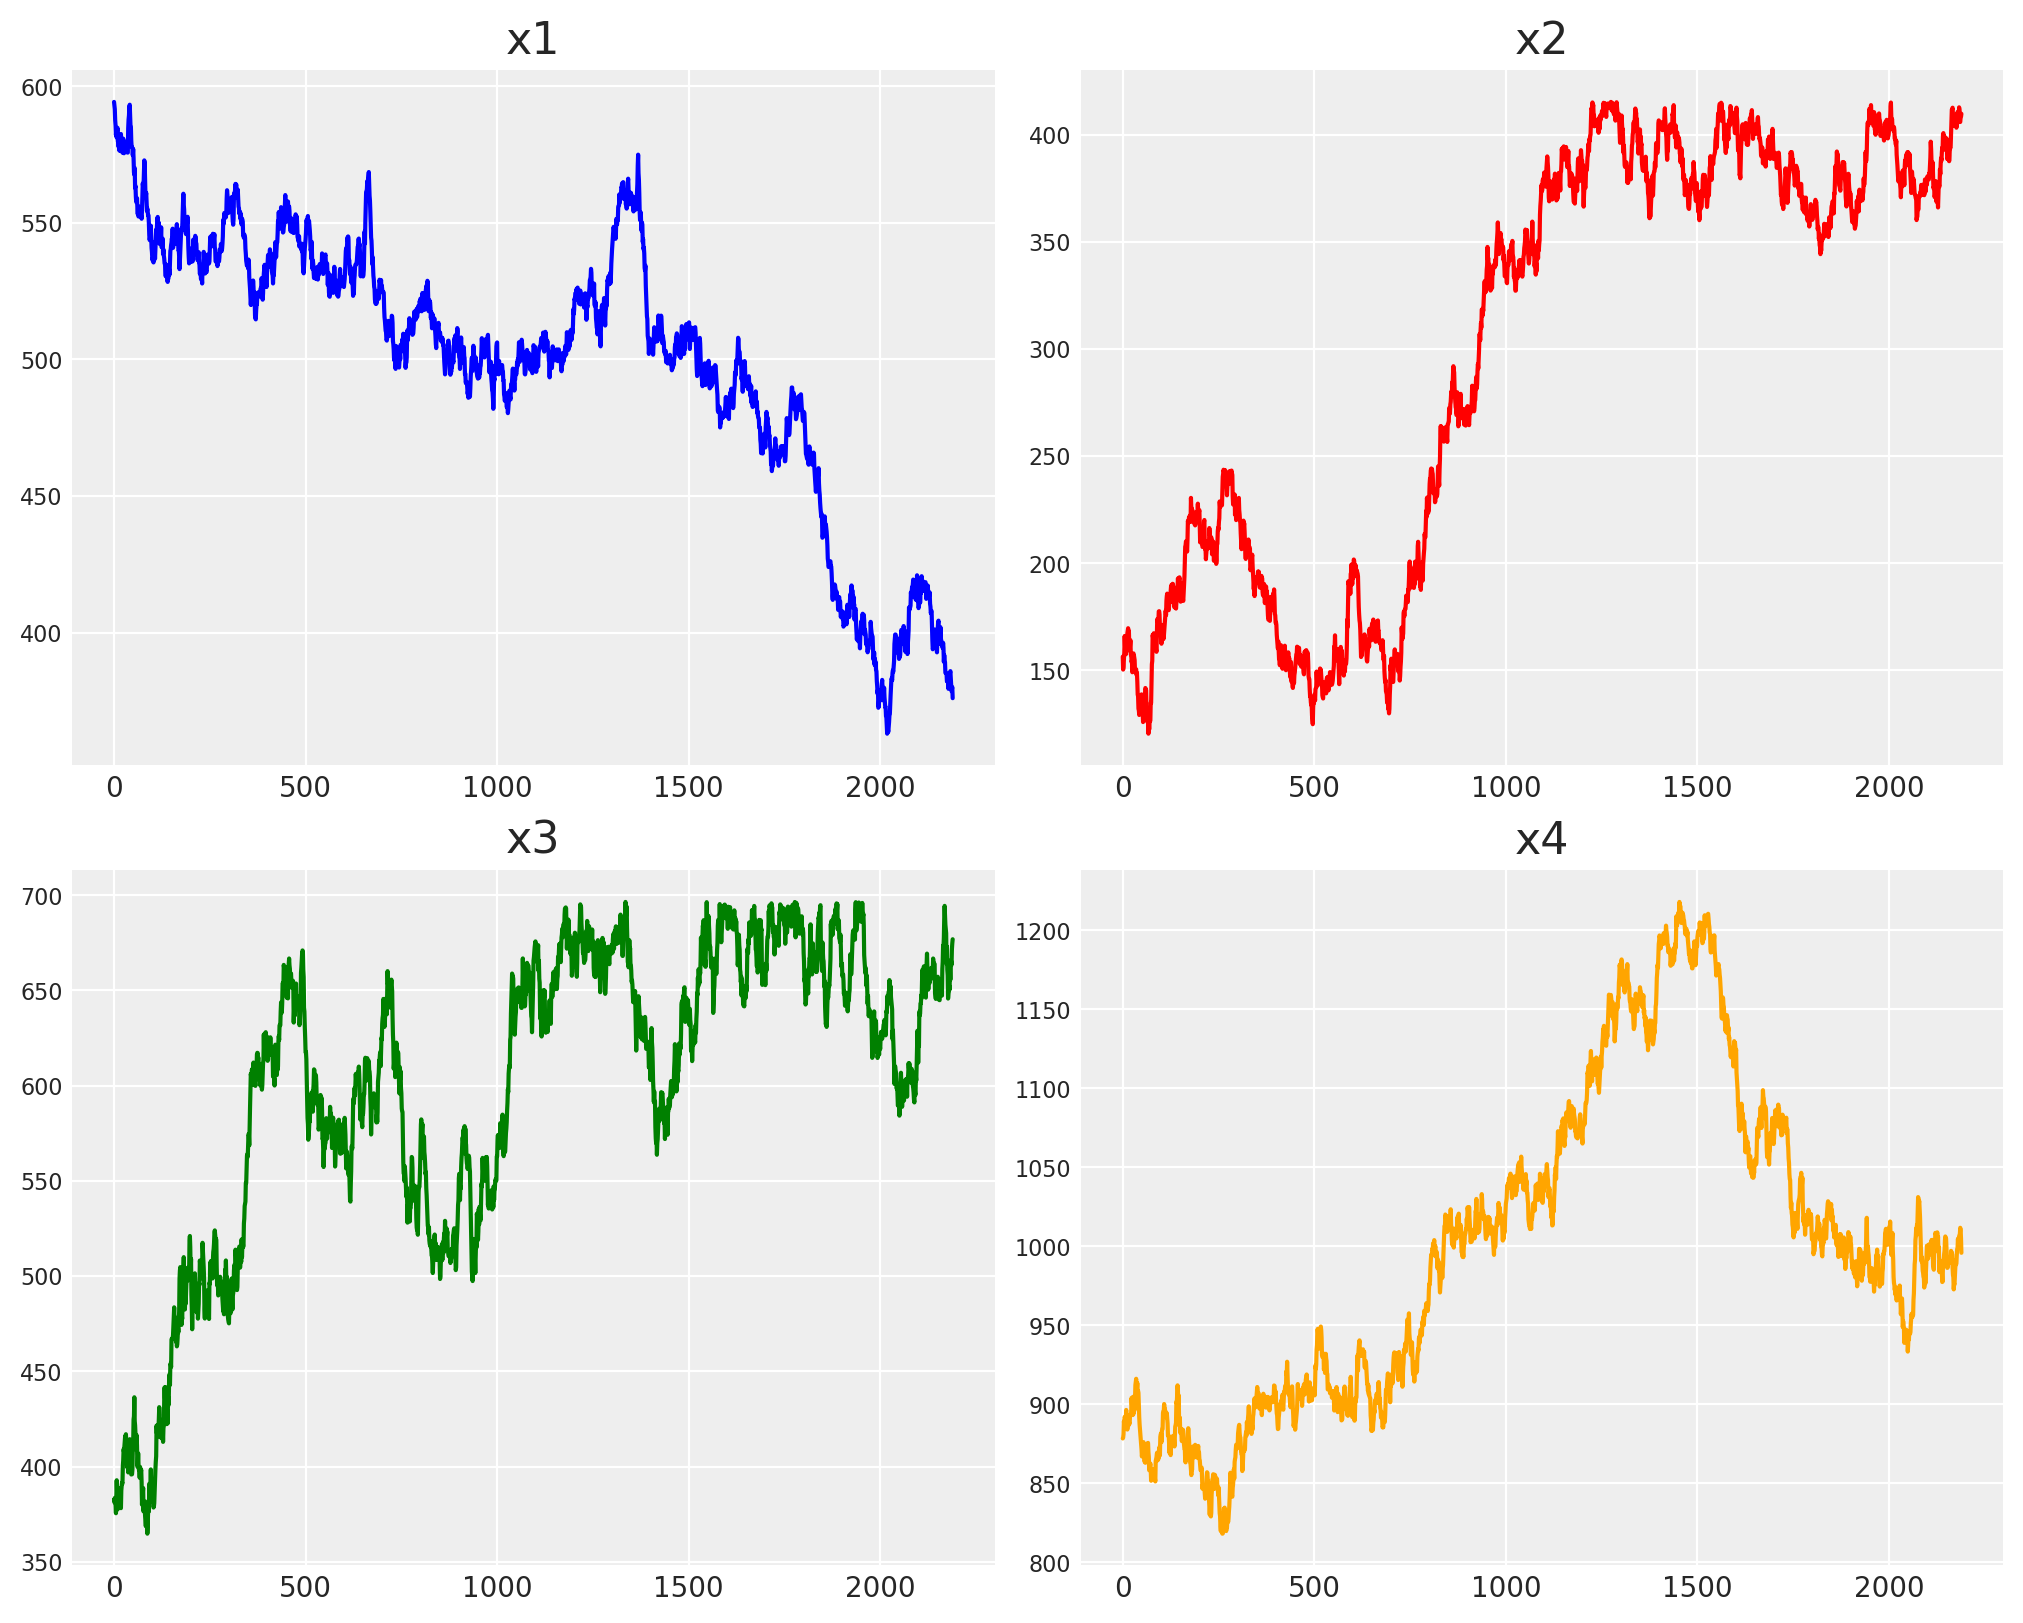

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(x1, color="blue")
axs[0, 0].set_title("x1")
axs[0, 1].plot(x2, color="red")
axs[0, 1].set_title("x2")
axs[1, 0].plot(x3, color="green")
axs[1, 0].set_title("x3")
axs[1, 1].plot(x4, color="orange")
axs[1, 1].set_title("x4")
plt.show()

We’ll build a simple linear model based on these four factors. You can think of them as representing impressions, spend, or any other typical marketing variable, while the target could correspond to outcomes such as revenue, installs, site registrations, or purchases.

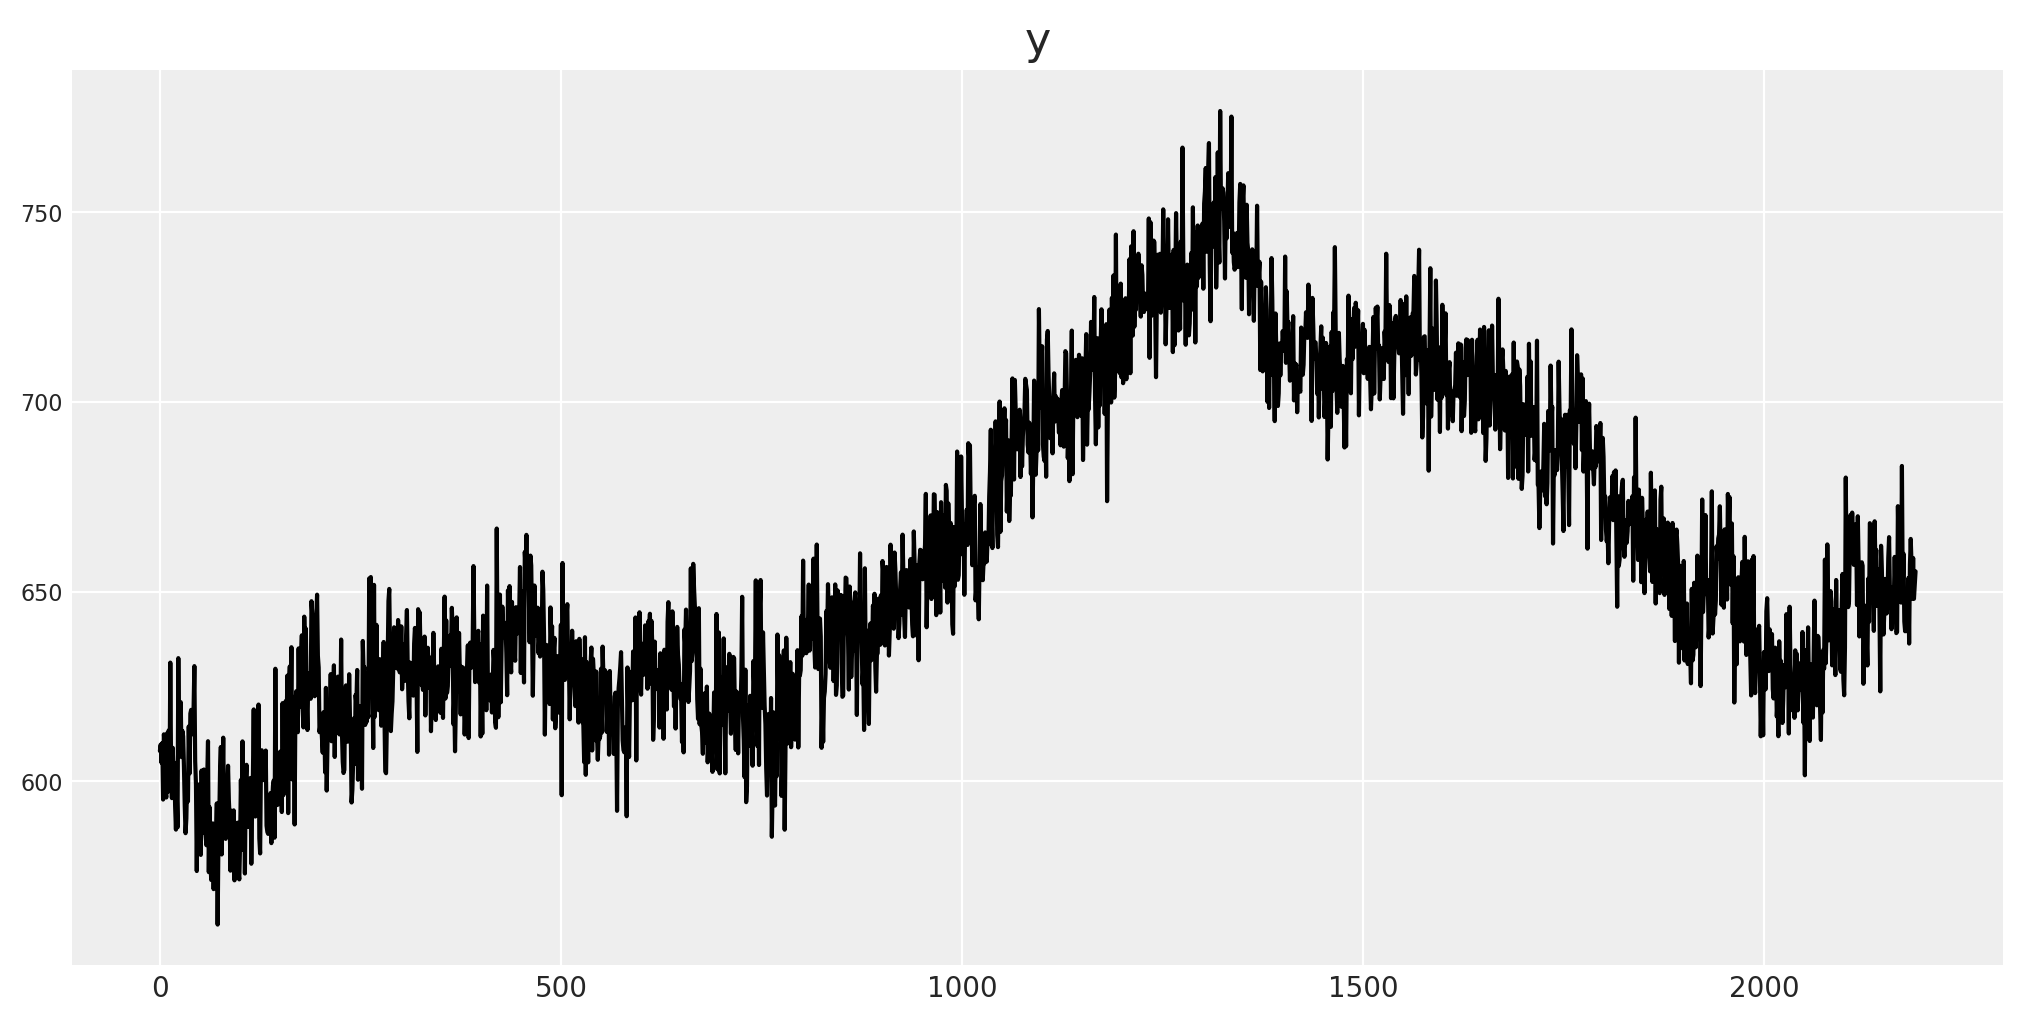

In [6]:
intercept = 100
noise = np.random.normal(0, 10, n_observations)
y = x1 * 0.5 + x2 * 0.3 + x3 * 0.2 + x4 * 0.1 + intercept + noise

df["x1"] = x1
df["x2"] = x2
df["x3"] = x3
df["x4"] = x4
df["y"] = y

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, color="black")
ax.set_title("y")
plt.show()

We put all the data together in the same dataset.

In [7]:
df.head()

date_week          x1          x2          x3          x4           y
0 2022-01-01  594.252746  156.373242  382.601781  878.408481  607.981630
1 2022-01-02  592.904201  150.323907  381.212926  878.912259  609.681360
2 2022-01-03  591.613607  151.588310  383.524140  881.134924  604.884320
3 2022-01-04  587.537071  154.705806  381.000766  889.327060  610.077574
4 2022-01-05  585.676798  158.286095  379.739704  886.491672  595.172633

## Sampler settings

We'll make a set of predifine sampler settings for all our models.

In [8]:
sample_kwargs = {
    "tune": 800,
    "draws": 200,
    "chains": 2,
    "random_seed": seed,
    "target_accept": 0.84,
}

## Simple Linear Model

To begin, we’ll construct a basic linear model using the `MMM` class. This example demonstrates how PyMC-Marketing can easily represent a standard linear regression.

::: {.callout-note}
PyMC-Marketing never forces the use of non-linearity. You can build purely linear models when that's what your data and business context require.
:::

In this setup, the target variable $Y_t$ is modeled as a linear combination of several predictors $X_{i,t}$, each weighted by its corresponding coefficient $b_i$, plus a random error term $\varepsilon_t$:

$$
Y_t = \sum_{i=1}^{I} b_i X_{i,t} + \varepsilon_t
$$

Here:
- $Y_t$ represents the target at time $t$ (e.g., revenue, installs, or registrations),
- $X_{i,t}$ are the explanatory variables (e.g., impressions, spend, or other marketing drivers),
- $b_i$ are the channel-specific coefficients capturing the marginal contribution of each variable, and
- $\varepsilon_t$ is the residual term accounting for unobserved variation.

::: {.callout-warning}
This case represents our precise previous data generation process, but the important thing is how easy it is to write this equation using the MMM API.
:::

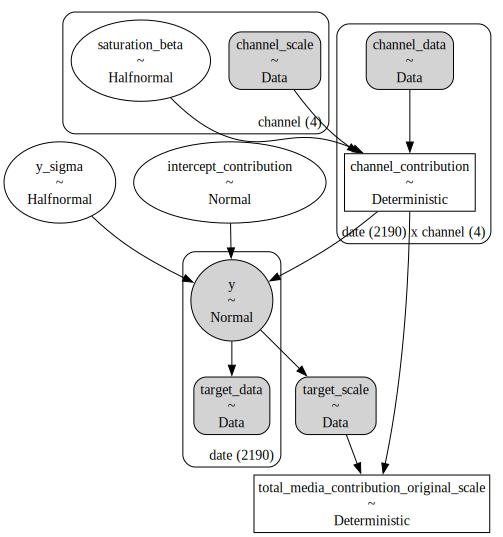

In [9]:
linear_model = MMM(
    date_column="date_week",
    target_column="y",
    channel_columns=["x1", "x2", "x3", "x4"],
    adstock=NoAdstock(l_max=1),
    saturation=NoSaturation().set_dims_for_all_priors("channel"),
    sampler_config=sample_kwargs,
)
linear_model.build_model(
    X=df.drop(columns=["y"]),
    y=df["y"],
)
linear_model.model.to_graphviz()

With just a few lines of code, you can define a linear model that already includes flexible prior configurations and multidimensional structure.  

The real advantage, however, isn’t just building a more complex graphical model so easily — it’s gaining access to all the powerful tools that PyMC-Marketing provides, even for a simple regression.

PyMC-Marketing gives you, out of the box:
- **Automatic scaling and rescaling** of inputs and outputs.  
- **Comprehensive plotting tools** for posterior evaluation.  
- **Sensitivity and marginal effect analysis** for each node in the model.  
- **Model calibration** using experimental or causal evidence.  
- **Budget allocation and optimization** capabilities.

All these features are available even for the simplest models, allowing you to move seamlessly from basic regressions to full probabilistic marketing frameworks.

Once every model is ready, you can train them in the very same way!

In [10]:
linear_model.add_original_scale_contribution_variable(
    ["channel_contribution", "y", "intercept_contribution"]
)

linear_model.fit(
    X=df.drop(columns=["y"]),
    y=df["y"],
)

linear_model.sample_posterior_predictive(
    X=df.drop(columns=["y"]),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept_contribution, saturation_beta, y_sigma]


Output()

Sampling 2 chains for 800 tune and 200 draw iterations (1_600 + 400 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 14MB
Dimensions:           (date: 2190, sample: 400)
Coordinates:
  * date              (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * sample            (sample) object 3kB MultiIndex
  * chain             (sample) int64 3kB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
  * draw              (sample) int64 3kB 0 1 2 3 4 5 ... 194 195 196 197 198 199
Data variables:
    y                 (date, sample) float64 7MB 0.793 0.7798 ... 0.8308 0.8248
    y_original_scale  (date, sample) float64 7MB 615.9 605.7 ... 645.3 640.6
Attributes:
    created_at:                 2025-10-08T16:44:41.761879+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

As you can see, we already create a model, add variables to be transform in original scale, and train it. All of these is saved into my object. How could we make this a little more complex?

Before go there, we'll need to add something else to our data, in this case, we'll add a few extra dimensions, in order to have a larger dataset.

In [11]:
countries = ["Venezuela", "Colombia", "Ecuador", "Panama"]
regions = ["South", "North", "East", "West"]
product_types = ["Type A", "Type B", "Type C", "Type D"]

multi_country_df = pd.DataFrame(
    [
        {
            "date_week": date,
            "country": country,
            "region": region,
            "product_type": product_type,
        }
        for country in countries
        for region in regions
        for product_type in product_types
        for date in date_range
    ]
)

# Create columns x1, x2, x3, x4 -> They must have for each combination of dimensions the N observations
for country_idx, country in enumerate(countries):
    for region_idx, region in enumerate(regions):
        for product_idx, product_type in enumerate(product_types):
            combination_mask = (
                (multi_country_df["country"] == country)
                & (multi_country_df["region"] == region)
                & (multi_country_df["product_type"] == product_type)
            )

            for col_idx, col in enumerate(["x1", "x2", "x3", "x4"]):
                mu = np.random.uniform(700, 800)
                sigma = np.random.uniform(50, 100)
                _seed = np.random.uniform(5, 30)
                walk_values = random_walk(
                    mu=mu,
                    sigma=sigma,
                    steps=n_observations,
                    lower=10,
                    upper=1000,
                    seed=seed
                    + country_idx * 100
                    + region_idx * 10
                    + product_idx * 1000
                    + col_idx,
                )
                multi_country_df.loc[combination_mask, col] = walk_values

multi_country_df.head()

date_week    country region product_type          x1          x2  \
0 2022-01-01  Venezuela  South       Type A  714.747082  993.519770   
1 2022-01-02  Venezuela  South       Type A  716.953241  990.663375   
2 2022-01-03  Venezuela  South       Type A  717.338847  987.929730   
3 2022-01-04  Venezuela  South       Type A  716.774590  979.295094   
4 2022-01-05  Venezuela  South       Type A  717.291722  975.354792   

           x3          x4  
0  708.423948  720.931696  
1  701.594453  720.524073  
2  703.021921  719.319332  
3  706.541469  723.098782  
4  710.583494  727.213349

Now our dataset looks better, we have a time series with lenght day per each country, region and product type. Take a look to the number of time series only made for $x1$.

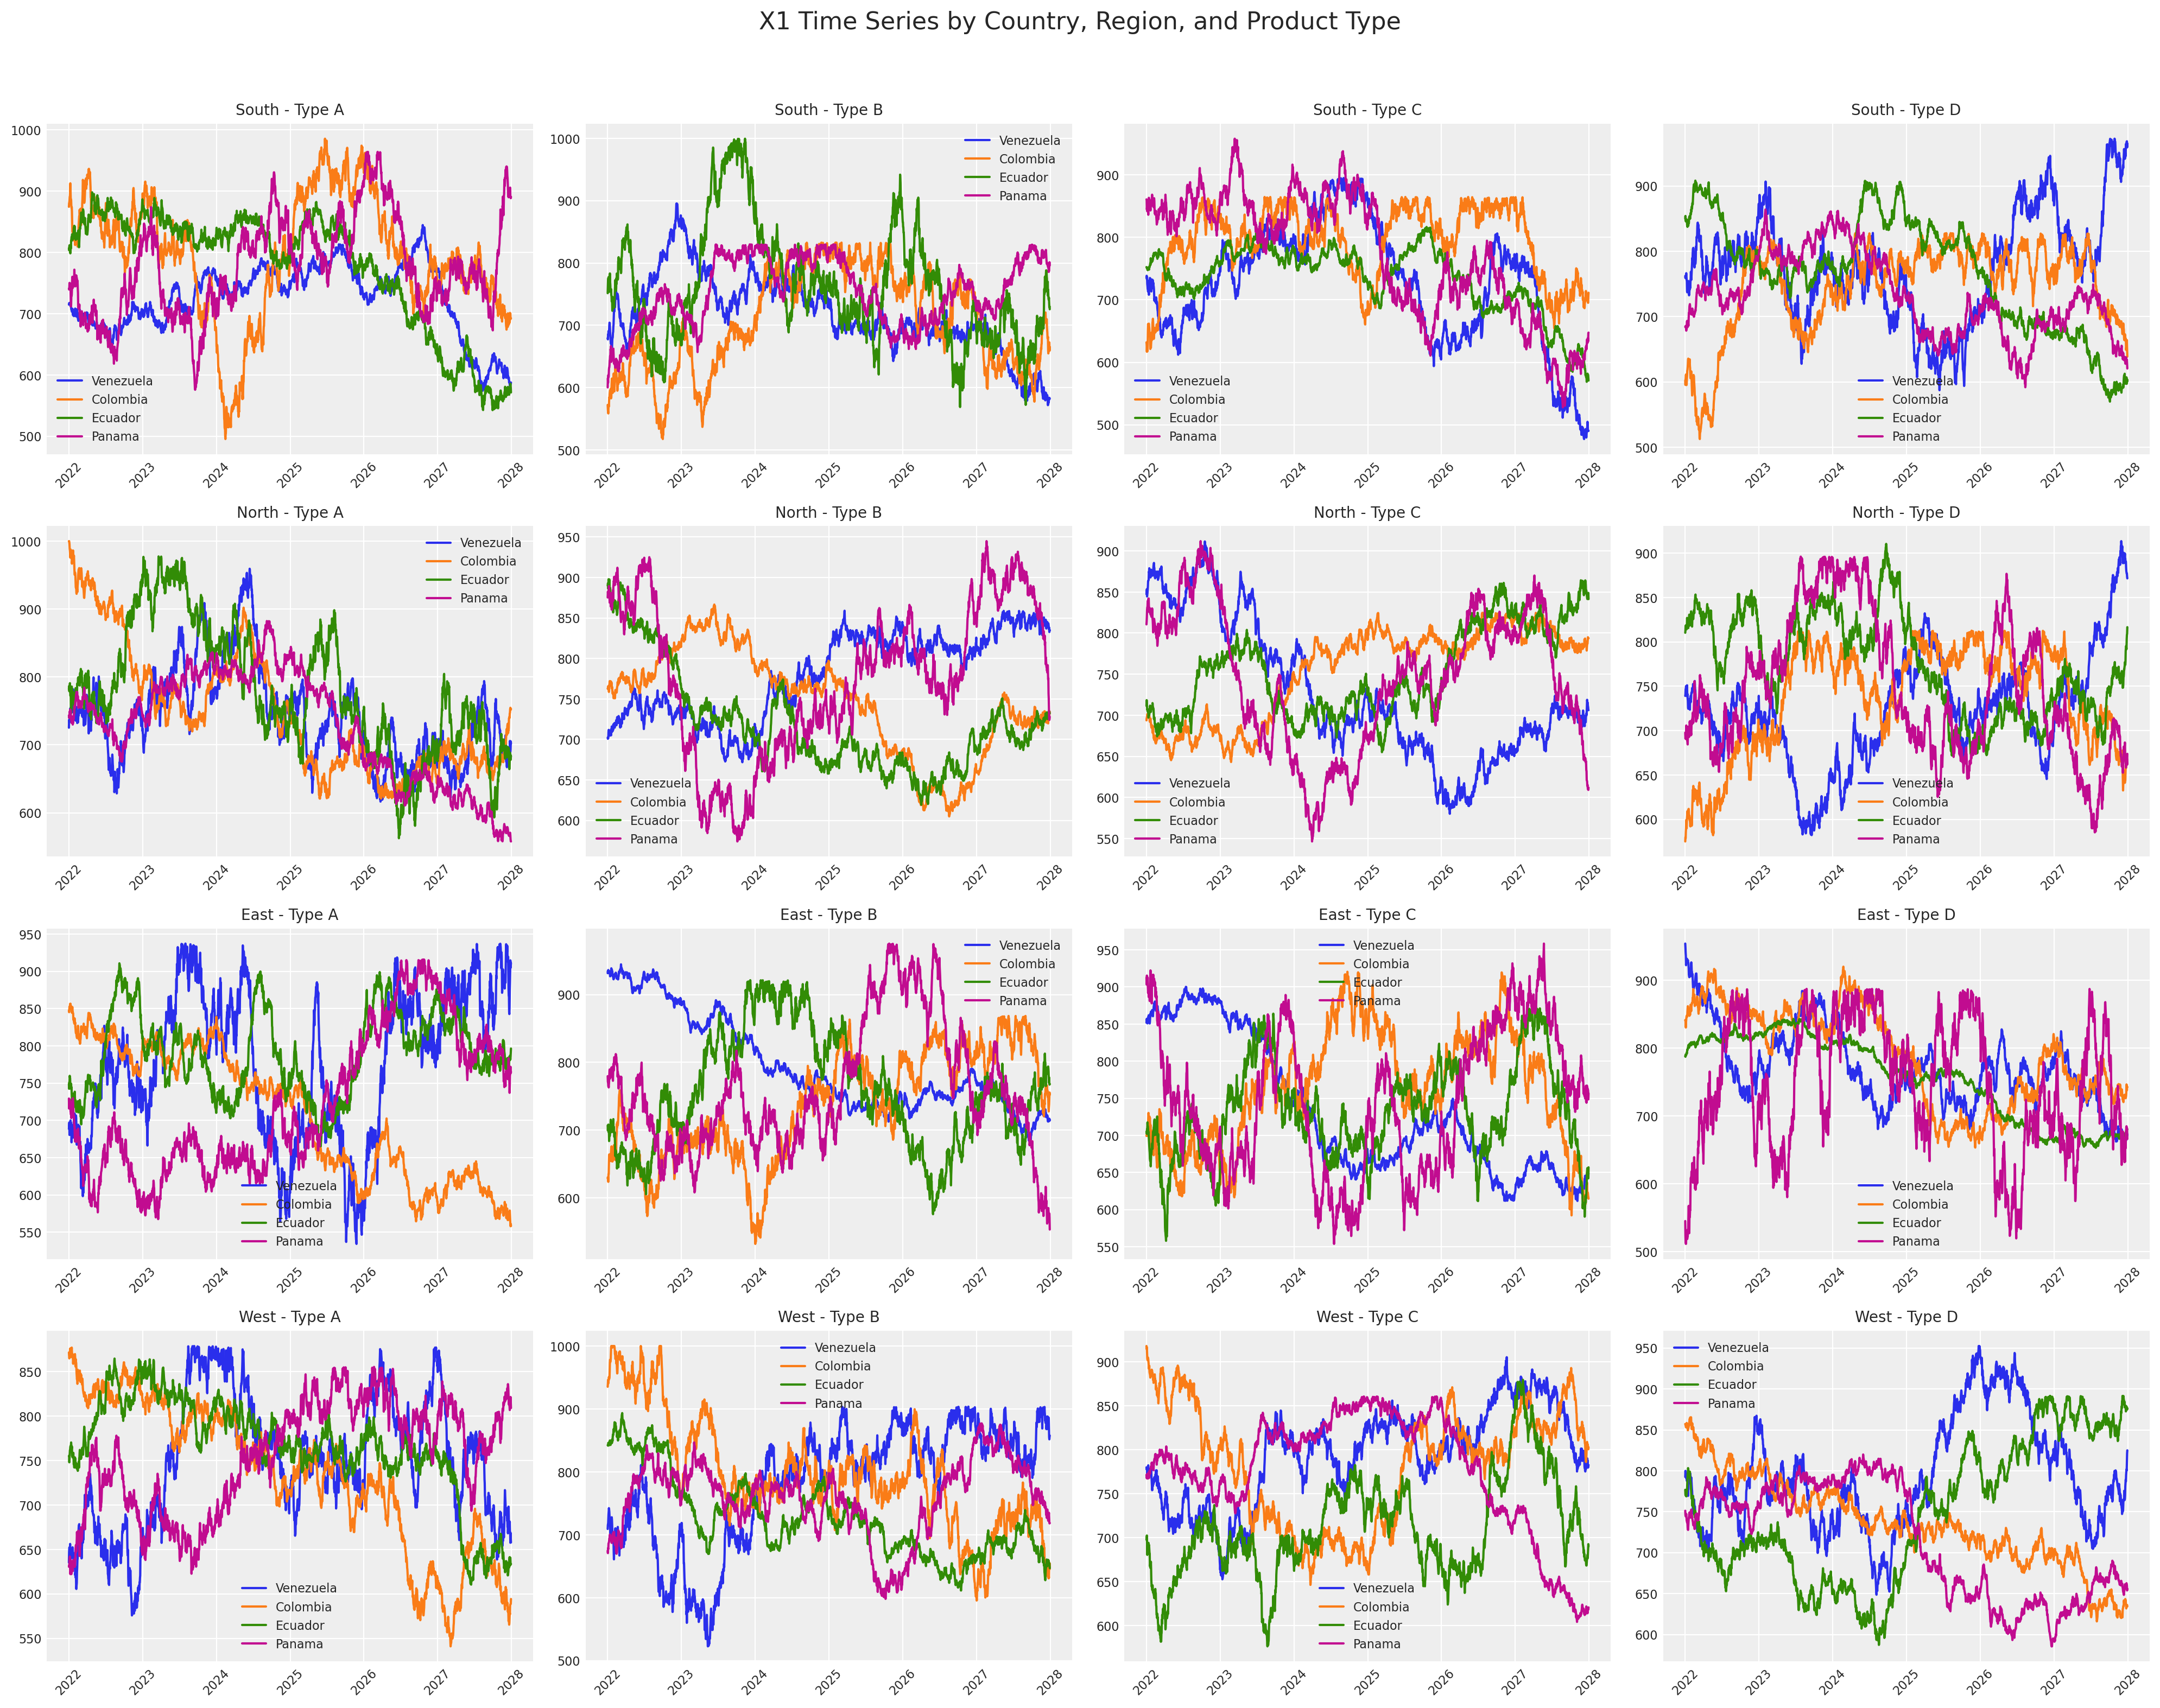

In [13]:
# Create subplots for each combination of country, region, and product type
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle("X1 Time Series by Country, Region, and Product Type", fontsize=16, y=0.98)

for _, country in enumerate(countries):
    for j, (region, product_type) in enumerate(
        [(r, p) for r in regions for p in product_types]
    ):
        if j >= 16:  # Only plot first 16 combinations to fit in 4x4 grid
            break

        row = j // 4
        col = j % 4

        # Filter data for this specific combination using query syntax
        subset = multi_country_df.query(
            f"country == '{country}' and region == '{region}' and product_type == '{product_type}'"
        )

        if len(subset) > 0:  # Only plot if data exists
            subset = subset.set_index("date_week")
            axes[row, col].plot(subset.index, subset["x1"], label=f"{country}")
            axes[row, col].set_title(f"{region} - {product_type}", fontsize=10)
            axes[row, col].tick_params(axis="x", rotation=45, labelsize=8)
            axes[row, col].tick_params(axis="y", labelsize=8)
            axes[row, col].legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

For each time series, we'll make a linear combination as before to get a target variable!

In [14]:
# Define different coefficients, intercepts, and noise levels for each combination
combination_params = {}

# Create parameters for each combination of country, region, and product type
for country in countries:
    for region in regions:
        for product_type in product_types:
            # Create unique parameters for each combination
            base_coeffs = [0.5, 0.3, 0.2, 0.1]
            base_intercept = 100
            base_noise = 10

            # Add variation based on country
            country_multiplier = {
                "Venezuela": 1.2,
                "Colombia": 1.0,
                "Ecuador": 0.9,
                "Panama": 1.1,
            }[country]

            # Add variation based on region
            region_multiplier = {"North": 1.1, "South": 0.9, "East": 1.0, "West": 0.95}[
                region
            ]

            # Add variation based on product type
            product_multiplier = {
                "Type A": 1.05,
                "Type B": 0.95,
                "Type C": 1.0,
                "Type D": 0.98,
            }[product_type]

            # Calculate final parameters
            final_multiplier = (
                country_multiplier * region_multiplier * product_multiplier
            )

            combination_params[(country, region, product_type)] = {
                "coeffs": [c * final_multiplier for c in base_coeffs],
                "intercept": base_intercept * final_multiplier,
                "noise_std": base_noise
                * (final_multiplier * 0.5 + 0.5),  # Moderate noise variation
            }

# Initialize y column
multi_country_df["y"] = 0.0

# Calculate y for each combination with different parameters
for (country, region, product_type), params in combination_params.items():
    combination_mask = (
        (multi_country_df["country"] == country)
        & (multi_country_df["region"] == region)
        & (multi_country_df["product_type"] == product_type)
    )

    if combination_mask.sum() > 0:
        # Generate combination-specific noise
        combination_noise = np.random.normal(
            0, params["noise_std"], combination_mask.sum()
        )

        # Calculate y for this combination
        combination_y = (
            multi_country_df.loc[combination_mask, "x1"] * params["coeffs"][0]
            + multi_country_df.loc[combination_mask, "x2"] * params["coeffs"][1]
            + multi_country_df.loc[combination_mask, "x3"] * params["coeffs"][2]
            + multi_country_df.loc[combination_mask, "x4"] * params["coeffs"][3]
            + params["intercept"]
            + combination_noise
        )

        multi_country_df.loc[combination_mask, "y"] = combination_y

multi_country_df.head()

date_week    country region product_type          x1          x2  \
0 2022-01-01  Venezuela  South       Type A  714.747082  993.519770   
1 2022-01-02  Venezuela  South       Type A  716.953241  990.663375   
2 2022-01-03  Venezuela  South       Type A  717.338847  987.929730   
3 2022-01-04  Venezuela  South       Type A  716.774590  979.295094   
4 2022-01-05  Venezuela  South       Type A  717.291722  975.354792   

           x3          x4            y  
0  708.423948  720.931696  1102.670438  
1  701.594453  720.524073  1102.027251  
2  703.021921  719.319332  1091.637121  
3  706.541469  723.098782  1104.578468  
4  710.583494  727.213349  1100.395298

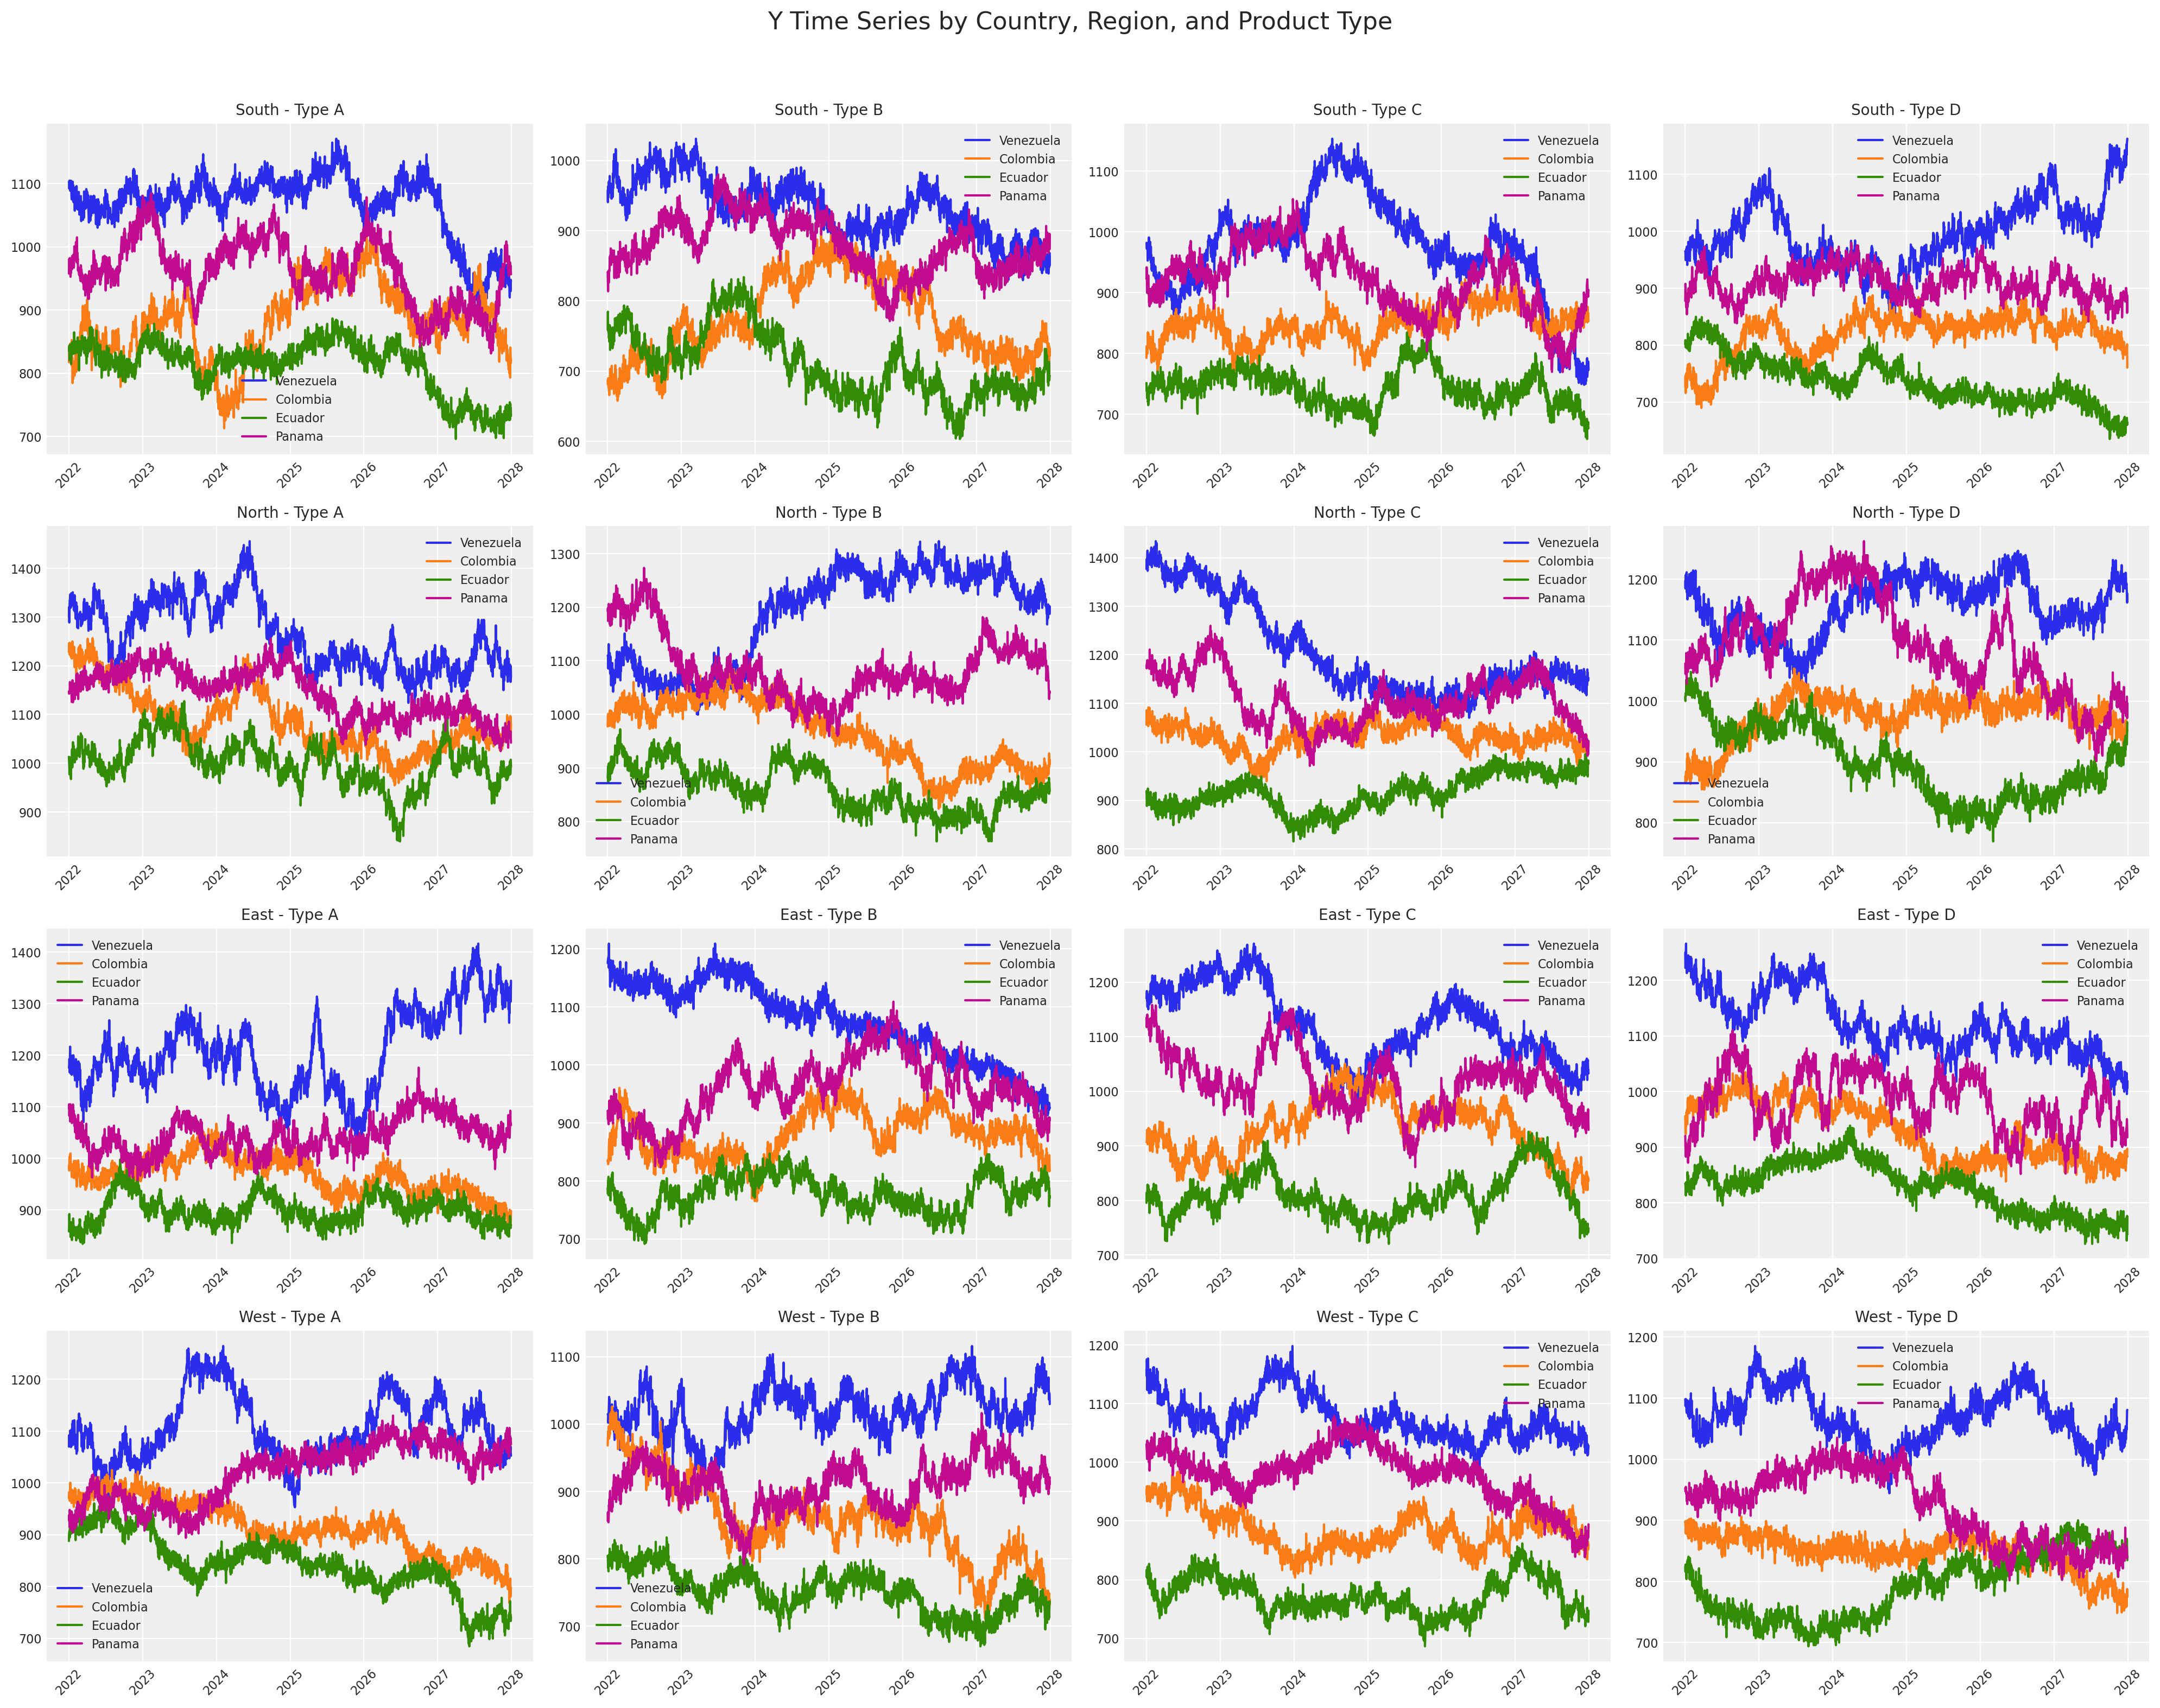

In [15]:
# Create subplots for each combination of country, region, and product type
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle("Y Time Series by Country, Region, and Product Type", fontsize=16)

for _, country in enumerate(countries):
    for j, (region, product_type) in enumerate(
        [(r, p) for r in regions for p in product_types]
    ):
        if j >= 16:  # Only plot first 16 combinations to fit in 4x4 grid
            break

        row = j // 4
        col = j % 4

        # Filter data for this specific combination
        # Filter data for this specific combination using query syntax
        subset = multi_country_df.query(
            f"country == '{country}' and region == '{region}' and product_type == '{product_type}'"
        )

        if len(subset) > 0:  # Only plot if data exists
            subset = subset.set_index("date_week")
            axes[row, col].plot(subset.index, subset["y"], label=f"{country}")
            axes[row, col].set_title(f"{region} - {product_type}", fontsize=10)
            axes[row, col].tick_params(axis="x", rotation=45, labelsize=8)
            axes[row, col].tick_params(axis="y", labelsize=8)
            axes[row, col].legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Adding additional dimensions into our additive model

If we wanted to build a similar linear model across multiple dimensions, it might seem like it would require a huge amount of code — right? **Short answer: no.**

With PyMC-Marketing, it only takes **one extra line**. By simply adding the `dims` parameter, you can include as many dimensions as your dataset contains, and the class will automatically handle all the structure and bookkeeping for you.


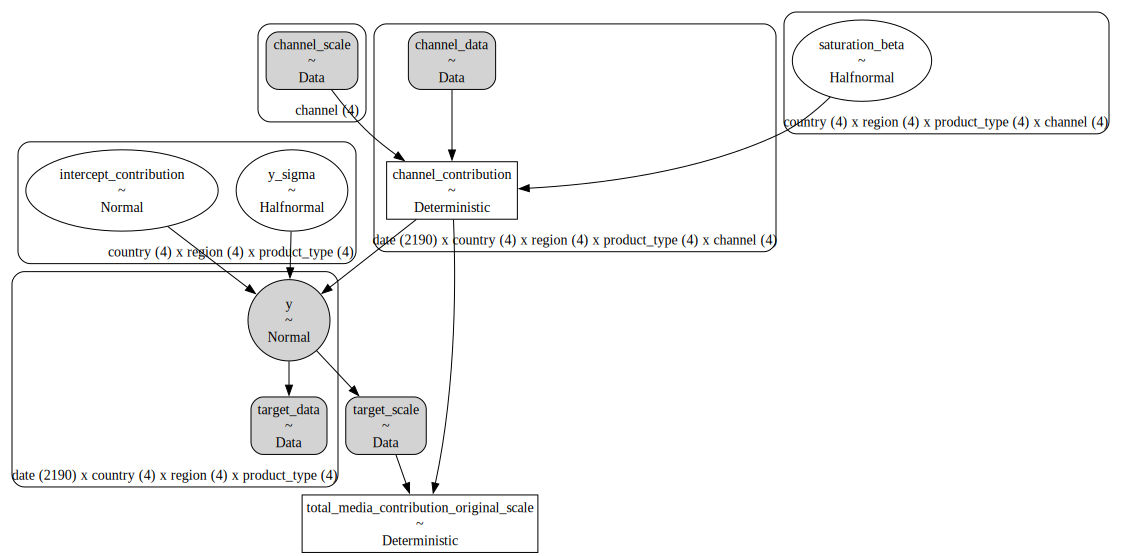

In [16]:
linear_model_with_country_dimensionality = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    adstock=NoAdstock(l_max=1),
    saturation=NoSaturation().set_dims_for_all_priors(
        ("country", "region", "product_type", "channel")
    ),
    # You can set priors for each country not needed country-channel
    sampler_config=sample_kwargs,
)
linear_model_with_country_dimensionality.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
linear_model_with_country_dimensionality.model.to_graphviz()

In [17]:
linear_model_with_country_dimensionality.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
)

Sampling: [intercept_contribution, saturation_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:09.972628+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

Now we have a **multidimensional model** that still represents the same linear function as before, but with additional indices across dimensions.  

### Creating hierarchical multidimensional model

Another great feature of PyMC-Marketing is its ability to **handle broadcasting automatically**. This means you don’t need to keep the same parameter shape for every random variable — you can adjust the parameter sizes as needed, and the `MMM` class will take care of the broadcasting for you.  

Here’s a quick example:

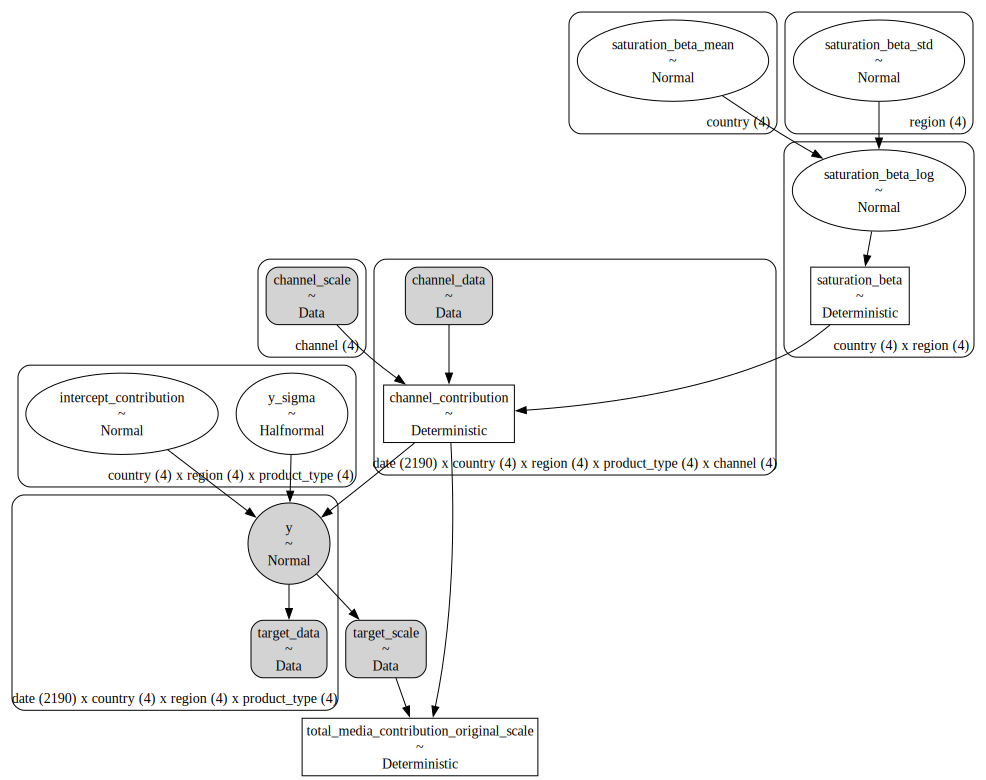

In [18]:
hierarchical_linear_model_with_country_dimensionality = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    adstock=NoAdstock(l_max=1),
    saturation=NoSaturation(
        priors={
            "beta": LogNormalPrior(
                mean=Prior("Normal", mu=1, sigma=2, dims="country"),
                std=Prior("Normal", mu=1, sigma=2, dims="region"),
                dims=("country", "region"),
            )
        }
    ),  # You can set priors for each country not needed country-channel
    sampler_config=sample_kwargs,
)
hierarchical_linear_model_with_country_dimensionality.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
hierarchical_linear_model_with_country_dimensionality.model.to_graphviz()

As you can see, it was incredibly easy to build a hierarchical model with higher dimensionality. However, there’s a small trade-off — as the model grows in size (both in parameters and data), sampling can start to take longer.  

We’ll explore several techniques to handle this more efficiently later on. For now, let’s quickly draw samples from the **prior predictive distribution** only!

In [19]:
hierarchical_linear_model_with_country_dimensionality.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [intercept_contribution, saturation_beta_log, saturation_beta_mean, saturation_beta_std, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:11.395366+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

### Adding Trend and Seasonality Components

To make our model more realistic, we can extend the linear structure by adding **trend** and **seasonality** components.  

PyMC-Marketing provides convenient classes for this: [`LinearTrend`](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.linear_trend.LinearTrend.html) and [`WeeklyFourier`](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.fourier.html).

The `LinearTrend` component introduces a piecewise linear trend with a configurable number of changepoints.  
It allows the model to adapt to shifts in long-term behavior, such as gradual growth or decay over time.  
Mathematically, the trend can be expressed as:

$$
\text{Trend}(t) = k \, t + \sum_{j=1}^{J} \delta_j \, s_j(t)
$$

where:
- $k$ represents the base slope,
- $\delta_j$ are changepoint adjustments, and
- $s_j(t)$ are indicator functions that activate after each changepoint.

The `WeeklyFourier` component captures **seasonal patterns** using a Fourier series representation.  
This is particularly useful for weekly or periodic effects in marketing data, such as cyclical user activity.  
The seasonal term can be written as:

$$
\text{Seasonality}(t) = \sum_{n=1}^{N} \big[ a_n \cos\!\left(\frac{2\pi n t}{P}\right) + b_n \sin\!\left(\frac{2\pi n t}{P}\right) \big]
$$

where $P$ is the period (e.g., 7 days for weekly cycles) and $N$ is the number of Fourier terms.

Again, add these complex terms is not difficult at all. Check the following example:

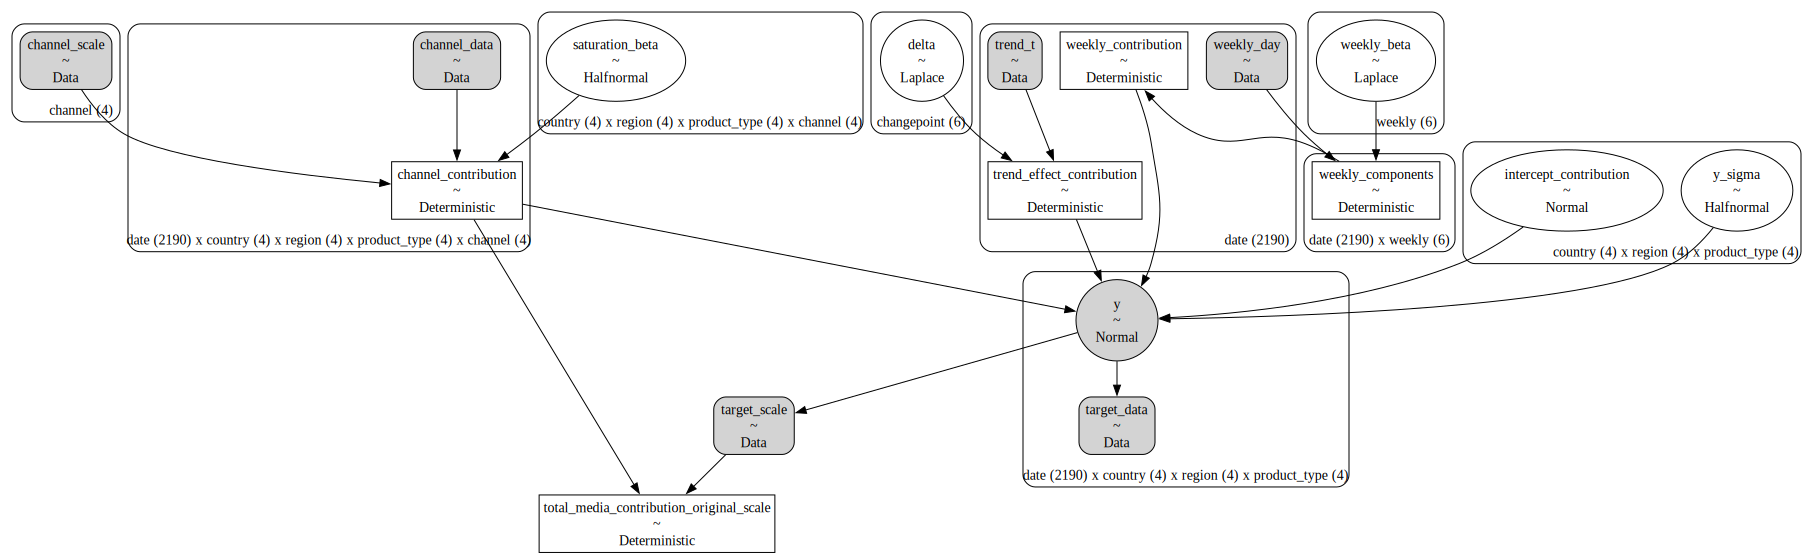

In [20]:
from pymc_marketing.mmm.additive_effect import FourierEffect, LinearTrendEffect
from pymc_marketing.mmm.fourier import WeeklyFourier
from pymc_marketing.mmm.linear_trend import LinearTrend

trend = LinearTrend(
    n_changepoints=6,
    include_intercept=False,
    dims=linear_model_with_country_dimensionality.dims,
)
trend_effect = LinearTrendEffect(trend=trend, prefix="trend")

weekly = WeeklyFourier(n_order=3, prefix="weekly")
weekly_effect = FourierEffect(fourier=weekly)

linear_model_with_country_dimensionality.mu_effects.extend(
    [trend_effect, weekly_effect]
)
linear_model_with_country_dimensionality.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
linear_model_with_country_dimensionality.model.to_graphviz()

In [21]:
linear_model_with_country_dimensionality.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [delta, intercept_contribution, saturation_beta, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:13.117839+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

Our model is becoming more sophisticated, yet it still represents a linear regression enriched with structural time-series components. But what if we want to capture more realistic marketing dynamics—such as **saturation** or **adstock effects**?  

That’s where we reach the true essence of **Marketing Mix Modeling (MMM)**. These components allow us to model how marketing impact evolves over time and how returns diminish as spend increases. How difficult is to replace our linear functions?

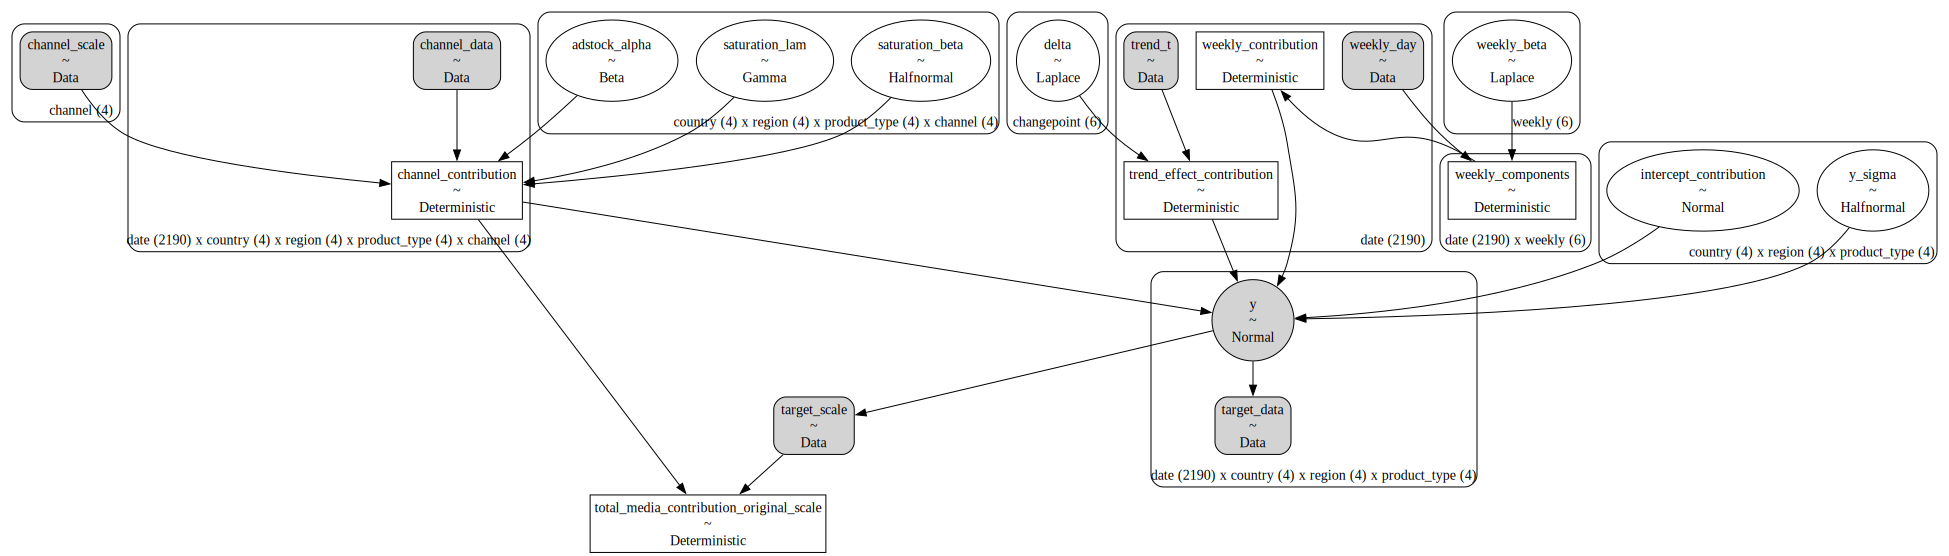

In [22]:
adstock = GeometricAdstock(l_max=6).set_dims_for_all_priors(
    ("country", "region", "product_type", "channel")
)
saturation = LogisticSaturation().set_dims_for_all_priors(
    ("country", "region", "product_type", "channel")
)

non_linear_model_with_country_dimensionality = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    adstock=adstock,
    saturation=saturation,
    sampler_config=sample_kwargs,
)
non_linear_model_with_country_dimensionality.mu_effects.extend(
    [trend_effect, weekly_effect]
)
non_linear_model_with_country_dimensionality.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
non_linear_model_with_country_dimensionality.model.to_graphviz()

In [23]:
non_linear_model_with_country_dimensionality.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
)

Sampling: [adstock_alpha, delta, intercept_contribution, saturation_beta, saturation_lam, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:15.561330+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

As you can see, the model has been growing in complexity while still relying entirely on PyMC-Marketing’s built-in components. 

What’s remarkable is that the amount of code remains almost identical to our very first linear model — meaning that building a nonlinear model with several structural time-series components takes virtually the same effort as a simple regression. How cool is that?

But what if we need a transformation that isn’t yet included in the PyMC-Marketing library? No problem — you can always define your own **custom functions** and specify exactly how each channel should be transformed.

For example, suppose you want your channels to contribute **exponentially** to the target. Can we do that? Absolutely!

## Custom functions in PyMC-Marketing

In [24]:
import pytensor.tensor as pt

from pymc_marketing.mmm.components.saturation import SaturationTransformation


class ExponentialTransformation(SaturationTransformation):
    """Exponential transformation of the input."""

    lookup_name = "exponential"

    def function(self, x, beta):
        """Transform the input using exponential function."""
        # beta * (1 - exp(-x))
        return beta * (1.0 - pt.exp(-x))

    # Choose sensible, positive prior for amplitude (beta)
    default_priors = {
        "beta": Prior("HalfNormal", sigma=2.0),
    }


custom_saturation = ExponentialTransformation(
    priors={
        "beta": Prior(
            "Beta",
            alpha=3,
            beta=Prior("HalfNormal", sigma=1),
            dims=("country", "region", "product_type", "channel"),
        ),
    },
    prefix="exponential",
)

If you follow the [`SaturationTransformation`](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.mmm.components.saturation.SaturationTransformation.html) protocol, you can easily implement any custom function and safely integrate it into your model.  

Since you’ll be working directly with PyMC’s internals, it may require a few extra lines of code — but PyMC-Marketing provides well-designed **base classes** that make this process much simpler and less error-prone.

This approach gives you full flexibility to design and test your own functional forms, while still benefiting from all the higher-level utilities of the library.

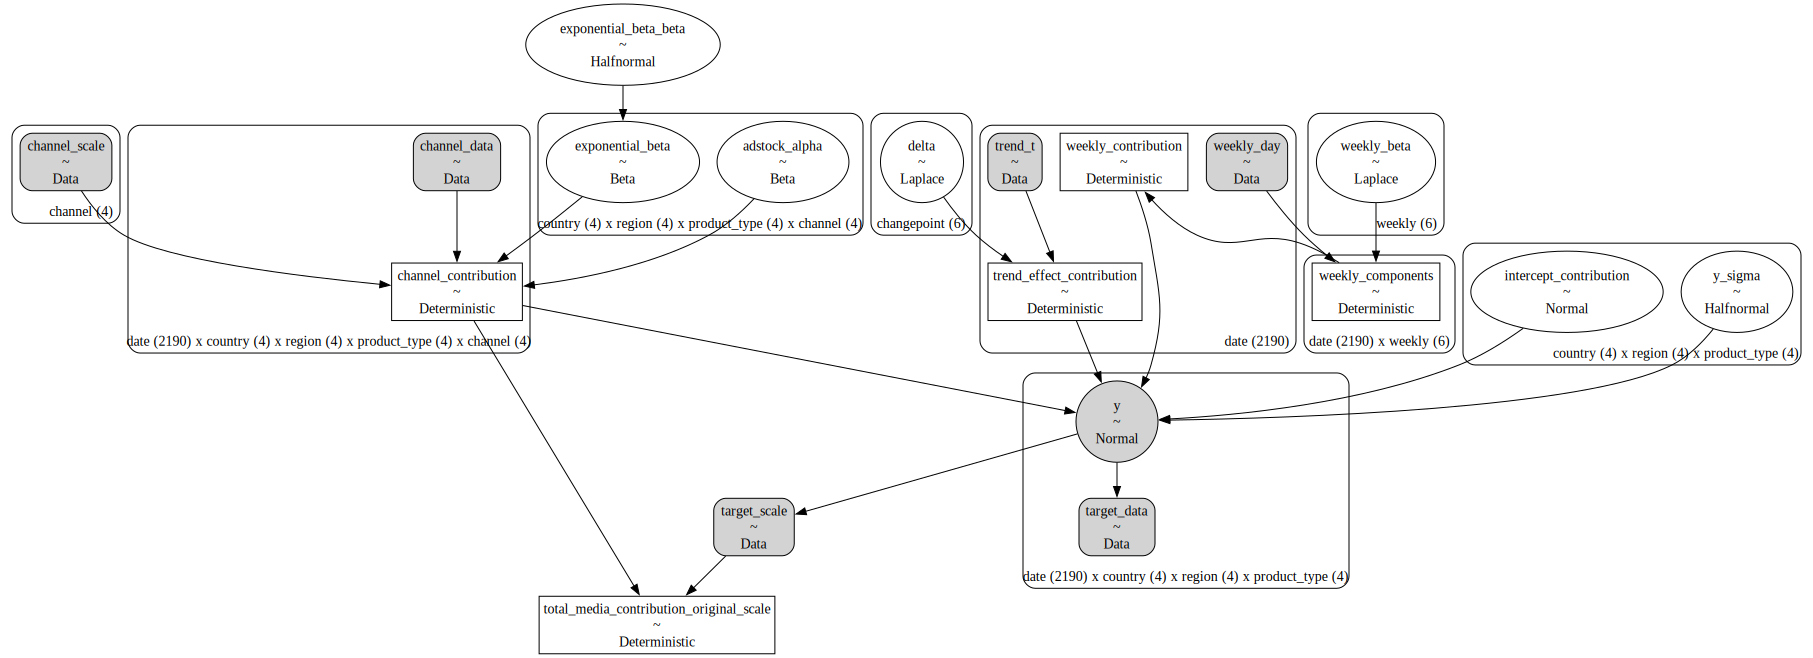

In [25]:
custom_non_linear_model_with_country_dimensionality = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    adstock=adstock,
    saturation=custom_saturation,
    sampler_config=sample_kwargs,
)
custom_non_linear_model_with_country_dimensionality.mu_effects.extend(
    [trend_effect, weekly_effect]
)
custom_non_linear_model_with_country_dimensionality.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
custom_non_linear_model_with_country_dimensionality.model.to_graphviz()

In [26]:
custom_non_linear_model_with_country_dimensionality.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [adstock_alpha, delta, exponential_beta, exponential_beta_beta, intercept_contribution, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:17.862277+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

Once again, we’ve expanded our model with only a minimal amount of additional code for the new transformation.  
The core API remains exactly the same — no extra setup, no additional boilerplate, and no juggling between components.  

And we’re still not done. We can keep enhancing our model by adding **extra linear components** for control variables. As usual, this only requires **a single line of code** — just one more parameter, and the rest of the workflow stays unchanged.

## Adding linear covariates

These additional variables are often referred to as **controls** — external covariates that help explain variations in the target which are not directly driven by our marketing channels. Examples might include macroeconomic indicators, competitor activity, or other contextual features such as weather or seasonality indexes.

In PyMC-Marketing, we can incorporate these controls as an **additional linear term** in the model’s mean function.  
Formally, if we denote our control variables as $Z_{i,t}$ and their corresponding coefficients as $\beta_{Z_i}$, the new model becomes:

$$
Y_t = \sum_{i=1}^{I} f(X_{i,t}, \theta_i) \;+\; \sum_{i=1}^{K} \beta_{Z_i} Z_{i,t} \;+\; . . . + \varepsilon_t
$$

Here:
- $X_{i,t}$ are the marketing drivers with parameters $\theta_i$,  
- $Z_{i,t}$ are the control covariates with parameters $\beta_{Z_i}$, and  
- $\varepsilon_t$ remains the residual noise term.

In practice, this means that after defining your main marketing components, you can simply pass your control variables to the model — typically as a tensor with shape `(date, control)` — and PyMC-Marketing will automatically handle the rest.

In [27]:
multi_country_df["control_a"] = multi_country_df["x1"] * 2 // multi_country_df["y"]
multi_country_df["control_b"] = multi_country_df["x4"] * 2 // multi_country_df["y"]

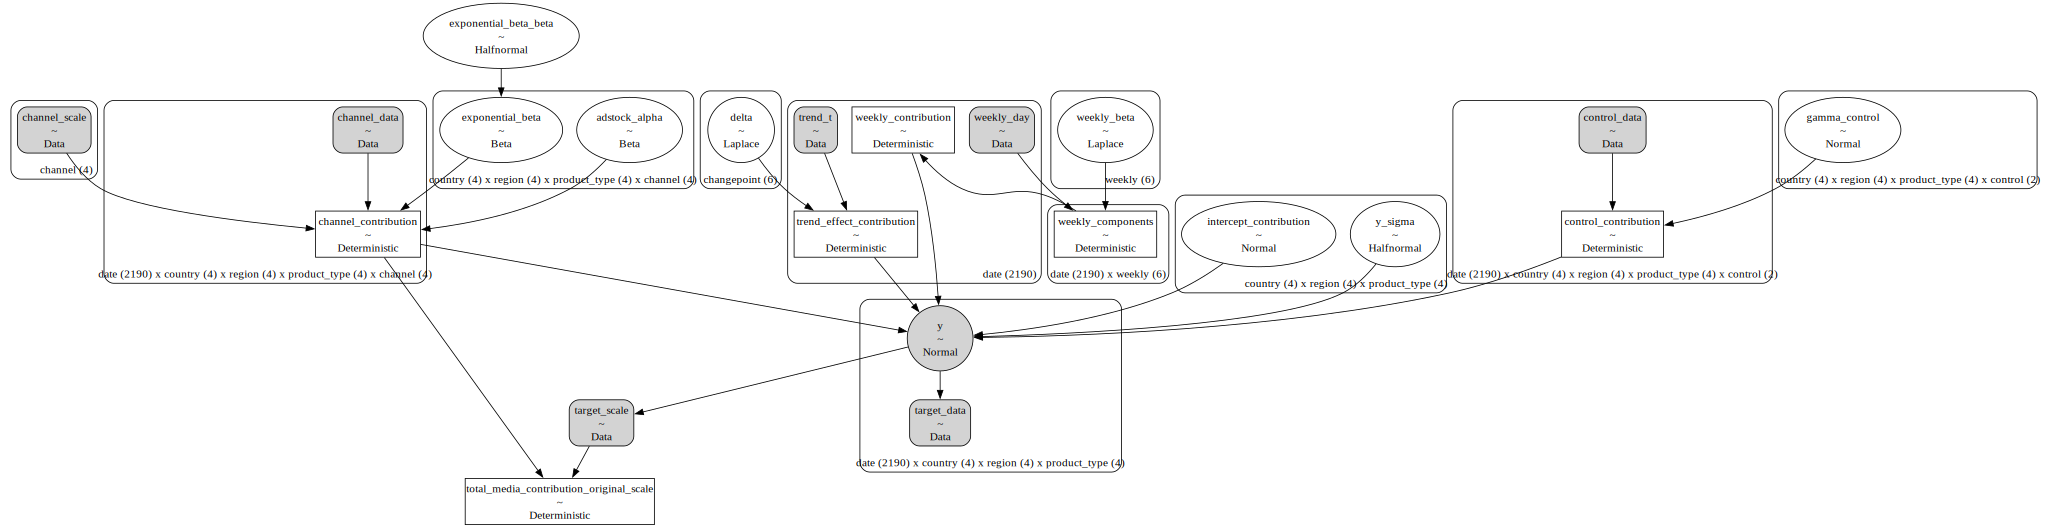

In [28]:
custom_non_linear_model_with_country_dimensionality_and_controls = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    control_columns=["control_a", "control_b"],
    adstock=adstock,
    saturation=custom_saturation,
    sampler_config=sample_kwargs,
)
custom_non_linear_model_with_country_dimensionality_and_controls.mu_effects.extend(
    [trend_effect, weekly_effect]
)
custom_non_linear_model_with_country_dimensionality_and_controls.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
custom_non_linear_model_with_country_dimensionality_and_controls.model.to_graphviz()

In [29]:
custom_non_linear_model_with_country_dimensionality_and_controls.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [adstock_alpha, delta, exponential_beta, exponential_beta_beta, gamma_control, intercept_contribution, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:20.510232+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

## Arbitrary terms in PyMC-Marketing

Sometimes you need a term that isn’t part of the built-ins. PyMC-Marketing lets you go fully custom: you can add **any** function of your inputs—of any shape or dimensionality—directly into the mean function. This does require a few more lines of code (you’re interfacing with PyMC internals), but the **protocol-based design** provides guardrails so you don’t break the model. The trade-off is straightforward: more flexibility and control in exchange for a bit more boilerplate. If you implement a class that follows the expected protocol, you can compose virtually anything.

In the example below, we introduce two custom pieces:

1) **A custom transformation** `InverseHillSaturation` that transforms inputs with an inverse-Hill form:

$$
f(x;\,\lambda,\beta) \;=\; \frac{\beta}{\,1 + (x/\lambda)^2\,}.
$$

2) **A wrapper effect** `TransformedControlsEffect` that (a) ingests a set of control covariates, (b) applies any `Transformation` (here, our custom InverseHillSaturation) respecting the model’s coordinates, and (c) **adds the resulting contribution into the mean** $\mu_t$. Concretely, if the special controls are $H_{k,t}$ with parameters $(\lambda_k, \beta_k)$, the additional term is:

$$
\textstyle
\mathrm{SpecialControls}(t)
\;=\;
\sum_{k=1}^{K}
\frac{\beta_k}{\,1 + (Z_{k,t}/\lambda_k)^2\,}.
$$

Putting this together with the existing marketing drivers $X_{i,t}$ and any standard linear controls, the mean function becomes:

$$
\textstyle
Y_t
=
\sum_{i=1}^{I} f(X_{i,t}, \theta_i)
\;+\;
\underbrace{\sum_{j=1}^{J} \beta_{Z_j} Z_{j,t}}_{\text{linear controls}}
\;+\;
\underbrace{\sum_{k=1}^{K}\frac{\beta_k}{1+(Z_{k,t}/\lambda_k)^2}}_{\text{special transformed controls}}
\;+\;
. . .
+
\varepsilon_t.
$$

What are those guardrails you must follow?

A component that you push into `mu_effects` is expected to behave like the examples in `pymc_marketing/mmm/additive_effect.py`. The implicit “*MuEffect protocol*” is only three methods, but each has to satisfy some invariants so that the class can be called during model build‐time and again later when the model is cloned for posterior-predictive sampling.

- `create effect`: Should return the tensor to be added additively to the model `mu_var`.
- `set_data`: Process to be able to run `sample_posterior_predictive` on existing or new data.
- `create_data`: Process to add the `pm.Data` container with the information for the custom component.

Don't forget the following 👇🏻
1. Unique names: choose a distinct prefix so your variables don’t collide with built-ins like "control_contribution".
Always add a deterministic with a “contribution” suffix if you want the user to retrieve it later; otherwise name clashes are possible.
2. Return dims: the tensor returned by create_effect must broadcast to the MMM target dims exactly (("date", *mmm.dims)). Failure to do so raises dimension errors when the model is summed.
3. Broadcasting helpers: when your internal effect has fewer dims, use create_dim_handler to align it.
4. Coordinate additions: if you introduce a new dimension (e.g. "event" or "fourier_mode"), add it once with model.add_coord(name, values) inside create_data.
5. Re-use pm.Data names consistently between create_data and set_data; otherwise pm.set_data can’t find the shared variable.
6. Do not mutate mmm.model.coords["date"]. If you need dates, read them from the coords; for new prediction dates, rely on the cloned model’s coords inside set_data.

Follow these rules and your component will plug into the MMM training, posterior sampling, and posterior-predictive workflows without surprises.

That being said, let's built our special covariates!

In [30]:
multi_country_df["control_special_c"] = (
    multi_country_df["x2"] * 2 // multi_country_df["y"]
)
multi_country_df["control_special_d"] = (
    multi_country_df["x3"] * 2 // multi_country_df["y"]
)

In [31]:
class InverseHillSaturation(SaturationTransformation):
    """Inverse Hill saturation transformation."""

    lookup_name = "inverse_hill"

    def function(self, x, lam, beta):
        """Transform the input using inverse Hill saturation."""
        # beta / (1 + (x / lam)**2)
        return beta / (1.0 + (x / lam) ** 2)

    # Choose sensible, positive priors for scale (lam) and amplitude (beta)
    default_priors = {
        "lam": Prior("HalfNormal", sigma=1.5),
        "beta": Prior("HalfNormal", sigma=2.0),
    }


class TransformedControlsEffect:
    """Wrap a custom transformation and add the transformed controls into μ."""

    def __init__(
        self,
        name: str,
        control_columns: Sequence[str],
        transformer: Transformation,
        dim_suffix: str = "control_tf",
    ) -> None:
        self.name = name
        self.control_columns = list(control_columns)
        # clone so we never mutate the transformer used by the main MMM
        self.transformer = deepcopy(transformer)
        self.dim_name = f"{name}_{dim_suffix}"
        self.data_name = f"{name}_data"

    # ------------------------------------------------------------------ helpers
    def _controls_to_xarray(self, mmm, df: pd.DataFrame) -> xr.DataArray:
        ds = mmm._create_xarray_from_pandas(
            data=df,
            date_column=mmm.date_column,
            dims=mmm.dims,
            metric_list=self.control_columns,
            metric_coordinate_name=self.dim_name,
        )
        return ds[f"_{self.dim_name}"].transpose("date", *mmm.dims, self.dim_name)

    def _build_dataset(self, mmm, df: pd.DataFrame) -> xr.DataArray:
        da = self._controls_to_xarray(mmm, df)
        return da.transpose("date", *mmm.dims, self.dim_name)

    # ----------------------------------------------------------------- protocol
    def create_data(self, mmm) -> None:
        """Create the data container for the transformed controls."""
        model: pm.Model = mmm.model
        df = mmm.X[[mmm.date_column, *mmm.dims, *self.control_columns]].copy()
        da = self._build_dataset(mmm, df)

        model.add_coord(self.dim_name, da.coords[self.dim_name].to_numpy())

        pm.Data(
            name=self.data_name,
            value=da.values,
            dims=("date", *mmm.dims, self.dim_name),
        )

    def create_effect(self, mmm):
        """Create the effect for the transformed control."""
        model: pm.Model = mmm.model

        transformed = pm.Deterministic(
            name=f"{self.name}_contribution",
            var=self.transformer.apply(
                x=model[self.data_name],
                dims=(*mmm.dims, self.dim_name),
            ),
            dims=("date", *mmm.dims, self.dim_name),
        )

        dim_handler = create_dim_handler(("date", *mmm.dims, self.dim_name))
        return dim_handler(transformed, ("date", *mmm.dims, self.dim_name)).sum(axis=-1)

    def set_data(self, mmm, model: pm.Model, X: xr.Dataset) -> None:
        """Set the data container for the transformed controls."""
        df = (
            X.to_dataframe()
            .reset_index()
            .loc[:, [mmm.date_column, *mmm.dims, *self.control_columns]]
        )
        da = self._build_dataset(mmm, df).reindex(
            {
                "date": model.coords["date"],
                **{dim: model.coords[dim] for dim in mmm.dims},
                self.dim_name: model.coords[self.dim_name],
            },
            fill_value=0,
        )
        pm.set_data({self.data_name: da.values}, model=model)

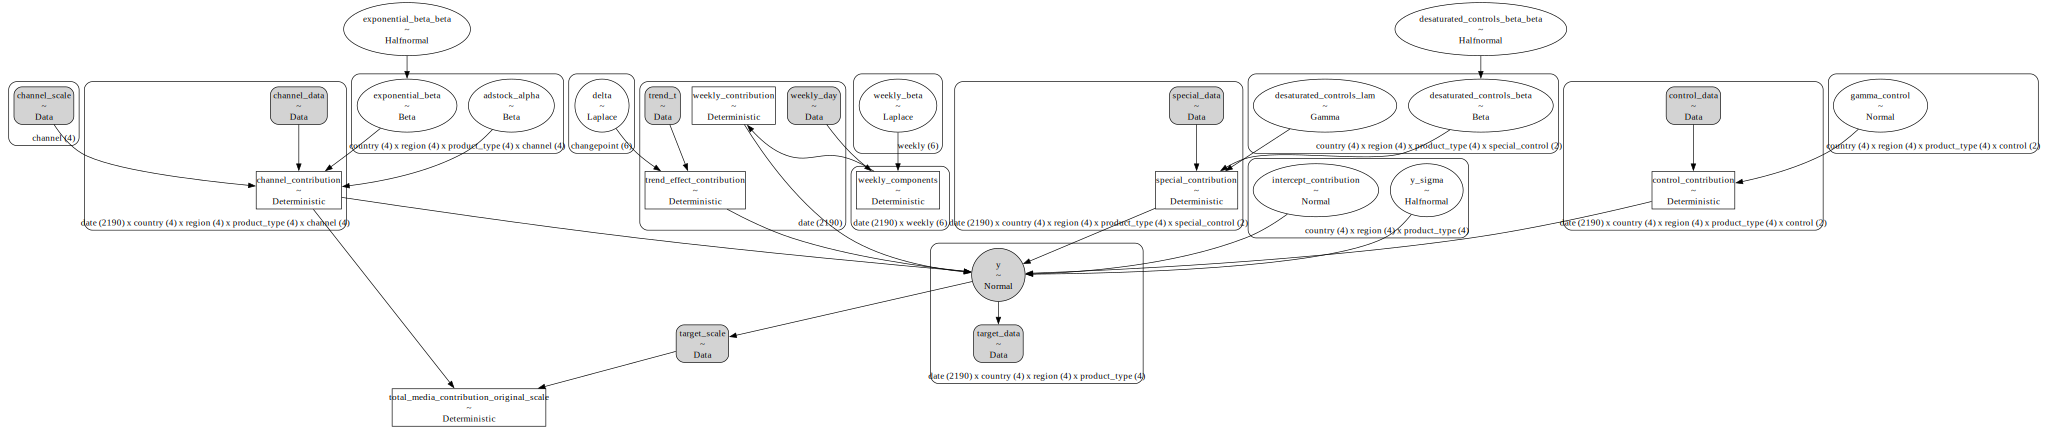

In [32]:
custom_control_sat = InverseHillSaturation(
    priors={
        "beta": Prior(
            "Beta",
            alpha=3,
            beta=Prior("HalfNormal", sigma=1),
            dims=("country", "region", "product_type", "special_control"),
        ),
        "lam": Prior(
            "Gamma",
            mu=1,
            sigma=2,
            dims=("country", "region", "product_type", "special_control"),
        ),
    },
    prefix="desaturated_controls",
)

effect = TransformedControlsEffect(
    name="special",
    control_columns=["control_special_c", "control_special_d"],
    transformer=custom_control_sat,
    dim_suffix="control",
)

custom_non_linear_model_with_country_dimensionality_and_controls_special = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    control_columns=["control_a", "control_b"],
    adstock=adstock,
    saturation=custom_saturation,
    sampler_config=sample_kwargs,
)

custom_non_linear_model_with_country_dimensionality_and_controls_special.mu_effects.extend(
    [trend_effect, weekly_effect]
)
custom_non_linear_model_with_country_dimensionality_and_controls_special.mu_effects.append(
    effect
)

custom_non_linear_model_with_country_dimensionality_and_controls_special.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
custom_non_linear_model_with_country_dimensionality_and_controls_special.model.to_graphviz()

In [33]:
custom_non_linear_model_with_country_dimensionality_and_controls_special.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [adstock_alpha, delta, desaturated_controls_beta, desaturated_controls_beta_beta, desaturated_controls_lam, exponential_beta, exponential_beta_beta, gamma_control, intercept_contribution, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:23.584251+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

## Recap: From Simple Lines to Complex Structures

Throughout this notebook, we’ve seen how **PyMC-Marketing** evolves from a simple linear regression into a flexible probabilistic framework capable of modeling rich time-series structures. We began with a basic linear model, showing how each component — adstock, saturation, trends, Fourier seasonality, and controls — can be added seamlessly using a consistent API and only a few lines of code. Each addition preserved the same conceptual foundation while expanding the expressive power of the model.

We introduced **dimensionality** (such as countries or regions) without adding complexity to the code, leveraged **broadcasting** to align parameters automatically, and integrated both **linear covariates** and **nonlinear transformations** to capture more realistic behaviors. Finally, we extended the system with **arbitrary effects**, where users can define their own transformations, saturation functions, or additive processes, provided they follow the library’s protocol-based design.

By doing so, your models can grow as much as you want in complexity — and you can rely on PyMC-Marketing to handle it elegantly. With minimal lines of code, you can increase dimensionality, enable automatic broadcasting, and add linear or nonlinear transformations, as well as linear covariates. And with just a few more lines, you can implement entirely custom transformations or arbitrary additive components tailored to your specific use case.

Of course, this flexibility comes at a cost: as your model grows, so does the number of parameters, sometimes to the point where sampling becomes computationally expensive or even infeasible. Let’s take a closer look at how the parameter count has evolved across our models so far — considering each random variable multiplied by its respective dimensionality.


In [34]:
# count and print the total number of parameters (considering dimensions) in each model
def count_total_parameters(model):
    """Count total parameters considering their dimensions."""
    total = 0
    for rv in model.free_RVs:
        # Get the size of the random variable (product of all dimensions)
        rv_size = rv.size.eval() if hasattr(rv.size, "eval") else rv.size
        total += rv_size
    return total


print(f"Total parameters in linear_model: {count_total_parameters(linear_model.model)}")
print(
    f"Total parameters in linear_model_with_country_dimensionality: "
    f"{count_total_parameters(linear_model_with_country_dimensionality.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality_and_controls.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls_special: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality_and_controls_special.model)}"
)

Total parameters in linear_model: 6
Total parameters in linear_model_with_country_dimensionality: 396
Total parameters in custom_non_linear_model_with_country_dimensionality: 653
Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls: 781
Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls_special: 1038


### Parameter Growth & Sampling Time

As the model evolved, the parameter count grew rapidly.

This illustrates a key reality of additive, multidimensional Bayesian models: **parameter space often grows super-linearly** (and can feel exponential) as you stack effects (trend, seasonality, adstock, saturation), add controls, and expand over indices (e.g., country, product, region). Computational cost typically rises with both **data size** and **parameter dimensionality**; for gradient-based MCMC like NUTS, wall-time per effective sample can increase sharply as posteriors become higher-dimensional and more correlated. That’s why we didn’t fit every variant here—much as we love writing notebooks, we don’t love writing them for **hours**. 😉

### Excluding Variables from Sampling with `MaskedPrior`

When models grow across many dimensions — countries, regions, product types, and channels — not every combination is meaningful or even observed in the data. For instance, some products may not be sold in certain countries, or some channels may not operate in specific regions. In those cases, it’s inefficient (and potentially misleading) to assign priors and sample parameters for every combination. That’s where **`MaskedPrior`** comes in.

`MaskedPrior` allows you to define priors only over the *active* subset of your parameter space.  
You provide it with:
- a **base prior** (e.g., `Prior("Normal", mu=0, sigma=1, dims=("country", "channel"))`), and  
- a **boolean mask** (`xarray.DataArray`) indicating which parameter entries should be active (`True`) or excluded (`False`).

Internally, `MaskedPrior` performs three main steps:
1. **Subset creation:** It builds a reduced variable over only the active entries (those marked `True` in the mask).  
2. **Sampling on active subset:** The sampler draws values only for this smaller subset, ignoring inactive combinations completely.  
3. **Expansion back to full shape:** The reduced variable is re-expanded to the original dimensional shape, filling inactive positions with deterministic zeros.  

See as the following, if you define a mask $M_{i,j} \in \{0,1\}$ over a parameter $\theta_{i,j}$, the masked parameter becomes:
$$
\tilde{\theta}_{i,j} = 
\begin{cases}
\theta_{i,j}, & \text{if } M_{i,j} = 1, \\\\
0, & \text{if } M_{i,j} = 0.
\end{cases}
$$
Sampling occurs only for the active subset:
$$
\{\theta_{i,j} : M_{i,j}=1\},
$$
and the total number of random variables is reduced to $\sum_{i,j} M_{i,j}$.

The benefits are significant:
- **Parameter reduction:** Only meaningful parameters are sampled, reducing computational burden and improving sampling efficiency.  
- **Faster convergence:** With fewer parameters, NUTS and ADVI can converge more quickly and stably.  
- **Structural clarity:** The mask explicitly documents which parameter combinations are valid in your model.  
- **Compatibility:** Masked priors integrate seamlessly with PyMC-Marketing’s components, like adstock and saturation transformations, through standard prior definitions.

In [35]:
# Helper to build a mask given excluded
def make_country_channel_mask(countries, channels, excluded_combinations):
    mask = xr.DataArray(
        np.ones(
            (len(countries), len(regions), len(product_types), len(channels)),
            dtype=bool,
        ),
        dims=("country", "region", "product_type", "channel"),
        coords={
            "country": countries,
            "region": regions,
            "product_type": product_types,
            "channel": channels,
        },
    )
    for country, region, product_type, channel in excluded_combinations:
        # Ensure labels match exactly your coords (e.g., "Venezuela", "Ecuador", "Colombia", "Panama")
        if (
            (country in mask.country.values)
            and (region in mask.region.values)
            and (product_type in mask.product_type.values)
            and (channel in mask.channel.values)
        ):
            mask.loc[
                dict(
                    country=country,
                    region=region,
                    product_type=product_type,
                    channel=channel,
                )
            ] = False
    return mask


feature_cols = [
    c
    for c in multi_country_df.columns
    if c
    not in (
        "date_week",
        "y",
        "country",
        "region",
        "product_type",
        "control_a",
        "control_b",
        "control_special_c",
        "control_special_d",
    )
]

excluded_combinations = [
    ("Venezuela", "South", "Type A", "x1"),
    ("Ecuador", "North", "Type B", "x3"),
    ("Colombia", "East", "Type C", "x4"),
    ("Panama", "West", "Type D", "x2"),
    ("Panama", "West", "Type D", "x4"),
    ("Venezuela", "West", "Type B", "x4"),
    ("Colombia", "West", "Type B", "x4"),
    ("Colombia", "East", "Type C", "x1"),
    # . . . add as many as you want
]
mask_cc = make_country_channel_mask(countries, feature_cols, excluded_combinations)

# Priors
adstock_masked = GeometricAdstock(
    l_max=6,
    priors={
        "alpha": MaskedPrior(
            Prior(
                "Beta",
                alpha=1,
                beta=1,
                dims=("country", "region", "product_type", "channel"),
            ),
            mask=mask_cc,
        )
    },
)

saturation_masked = ExponentialTransformation(
    priors={
        "beta": MaskedPrior(
            Prior(
                "Beta",
                alpha=3,
                beta=Prior("HalfNormal", sigma=1),
                dims=("country", "region", "product_type", "channel"),
            ),
            mask=mask_cc,
        ),
    },
    prefix="exponential",
)

This means PyMC-Marketing will not sample adstock or saturation parameters for those excluded combinations — instead, it fills those entries with deterministic zeros while maintaining full coordinate alignment.

By leveraging `MaskedPrior`, you can prune large models intelligently, maintaining structural consistency while dramatically reducing parameter space. This approach keeps your model both scalable and interpretable, especially when working with high-dimensional marketing datasets.

::: {.callout-warning}
The `MaskedPrior` functionality was merged recently and is still experimental. Use with caution in production environments.
:::

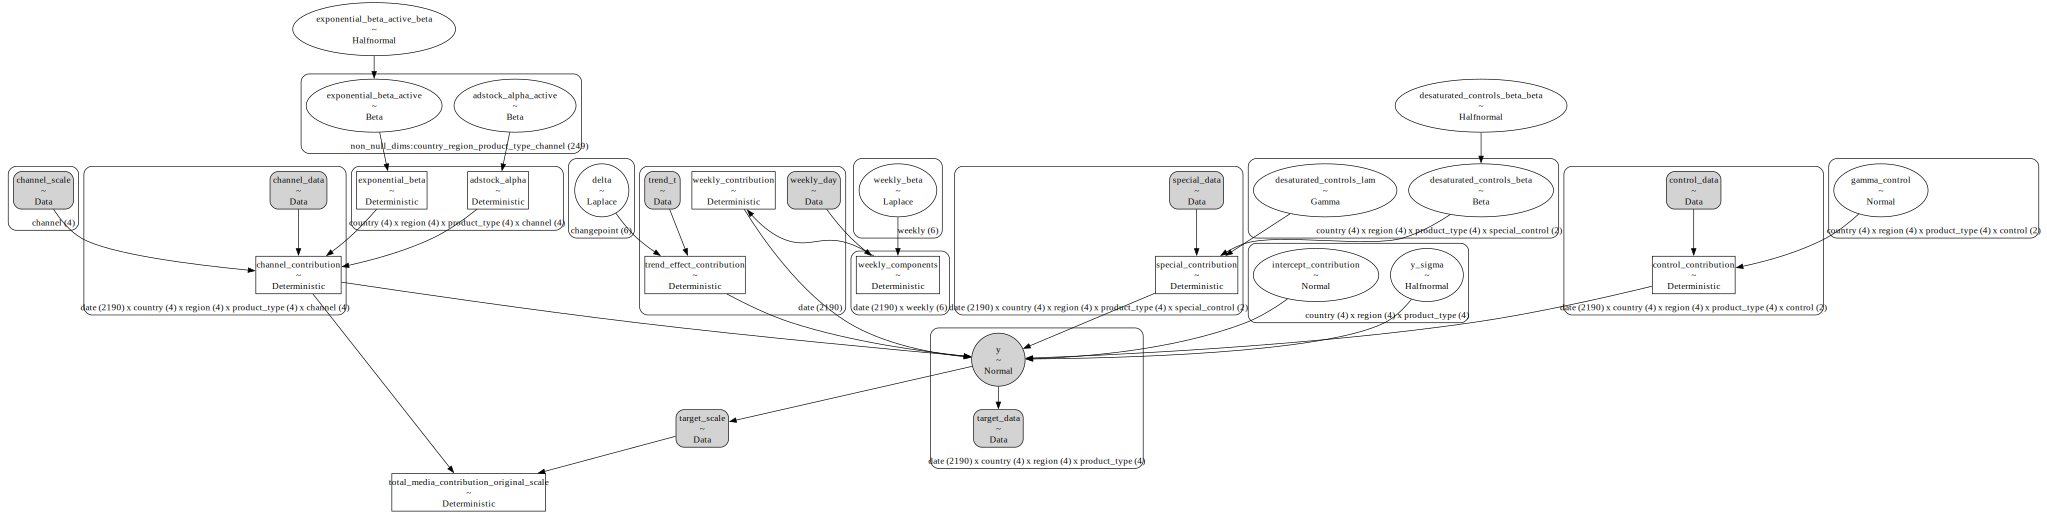

In [36]:
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked = MMM(
    date_column="date_week",
    target_column="y",
    dims=("country", "region", "product_type"),
    channel_columns=["x1", "x2", "x3", "x4"],
    control_columns=["control_a", "control_b"],
    adstock=adstock_masked,
    saturation=saturation_masked,
    sampler_config=sample_kwargs,
)
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.mu_effects.extend(
    [trend_effect, weekly_effect]
)
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.mu_effects.append(
    effect
)
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.build_model(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.model.to_graphviz()

In [37]:
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.sample_prior_predictive(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
)

Sampling: [adstock_alpha_active, delta, desaturated_controls_beta, desaturated_controls_beta_beta, desaturated_controls_lam, exponential_beta_active, exponential_beta_active_beta, gamma_control, intercept_contribution, weekly_beta, y, y_sigma]


<xarray.Dataset> Size: 224MB
Dimensions:       (date: 2190, country: 4, region: 4, product_type: 4,
                   sample: 200)
Coordinates:
  * date          (date) datetime64[ns] 18kB 2022-01-01 ... 2027-12-30
  * country       (country) <U9 144B 'Colombia' 'Ecuardo' 'Panama' 'Venezuela'
  * region        (region) <U5 80B 'East' 'North' 'South' 'West'
  * product_type  (product_type) <U6 96B 'Type A' 'Type B' 'Type C' 'Type D'
  * sample        (sample) object 2kB MultiIndex
  * chain         (sample) int64 2kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw          (sample) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    y             (date, country, region, product_type, sample) float64 224MB ...
Attributes:
    created_at:                 2025-10-08T10:35:26.890756+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.16.0

In [38]:
print(f"Total parameters in linear_model: {count_total_parameters(linear_model.model)}")
print(
    f"Total parameters in linear_model_with_country_dimensionality: "
    f"{count_total_parameters(linear_model_with_country_dimensionality.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality_and_controls.model)}"
)
print(
    f"Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls_special: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality_and_controls_special.model)}"
)
print(
    f"Total parameters in non_linear_model_with_country_dimensionality_masked: "
    f"{count_total_parameters(custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.model)}"
)

Total parameters in linear_model: 6
Total parameters in linear_model_with_country_dimensionality: 396
Total parameters in custom_non_linear_model_with_country_dimensionality: 653
Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls: 781
Total parameters in custom_non_linear_model_with_country_dimensionality_and_controls_special: 1038
Total parameters in non_linear_model_with_country_dimensionality_masked: 1024


## Variational inference for High Dimensional grids

We’ve already seen how dimensional design and `MaskedPrior` can **shrink parameter space** by excluding irrelevant combinations. However, there are regimes where this isn’t enough: as you add nonlinear transformations, trend/seasonality, multi-index structures, and custom effects, you can end up in **very high-dimensional** posterior geometries. In these cases, exact MCMC (e.g., NUTS) can become prohibitively expensive. This is where **approximate inference** shines. As Michael Betancourt aptly notes, *“In high dimensions, expectations are the only thing that makes sense.”* Approximations let you target informative summaries (e.g., posterior means, credible intervals) without paying the full cost of exact sampling.

PyMC-Marketing exposes PyMC’s **variational** and **approximate** methods directly, so you can switch from exact sampling to approximation with minimal code. For example, using **ADVI** via `pm.fit(...)` and then drawing samples from the approximation. This tool allows you to prototype and triage large models quickly. You can later escalate to full MCMC if the approximation looks adequate and the compute budget allows. For details on available approximation methods (e.g., ADVI, Full-Rank ADVI, SVGD), see the PyMC inference docs (search for “PyMC variational inference” and pm.fit).

::: {.callout-warning title="Approximations: Useful but Not Magic"}
- Bias–variance trade-off: Variational families can underestimate posterior variance and miss correlations.
- Pathologies in geometry: Multimodality, heavy tails, and strong curvature can break simple variational assumptions or lead to poor local optima.
- Diagnostics matter: Monitor ELBO trajectories, check stability of solutions, and compare against short pilot NUTS runs on reduced models when possible.
- Calibration risk: Downstream decisions (e.g., budget allocation) may be overconfident if variance is underestimated. Consider conservative policies or robust utilities.
:::

In [39]:
_start_time = time.time()
linear_model.approximate_fit(
    X=df.drop(columns=["y"]),
    y=df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)
_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 1,522.5


Output()

Approximation took 2.59 seconds


In [40]:
_start_time = time.time()
linear_model_with_country_dimensionality.approximate_fit(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)

_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 1.1839e+05


Output()

Approximation took 55.23 seconds


In [41]:
_start_time = time.time()
custom_non_linear_model_with_country_dimensionality.approximate_fit(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)
_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 75,842


Output()

Approximation took 115.07 seconds


In [42]:
_start_time = time.time()
custom_non_linear_model_with_country_dimensionality_and_controls.approximate_fit(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)
_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 1.3775e+05


Output()

Approximation took 125.10 seconds


In [43]:
_start_time = time.time()
custom_non_linear_model_with_country_dimensionality_and_controls_special.approximate_fit(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)
_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 1.5028e+05


Output()

Approximation took 146.84 seconds


In [44]:
_start_time = time.time()
custom_non_linear_model_with_country_dimensionality_and_controls_special_masked.approximate_fit(
    X=multi_country_df.drop(columns=["y"]),
    y=multi_country_df["y"],
    fit_kwargs={"method": "advi"},  # goes to pm.fit(...)
    sample_kwargs={"draws": 1_000},  # goes to approximation.sample(...)
)
_end_time = time.time()
elapsed_time = _end_time - _start_time
print(f"Approximation took {elapsed_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = 1.5e+05


Output()

Approximation took 155.33 seconds


### Final Thoughts

What we’ve explored here is just a glimpse of what **PyMC-Marketing** can do. Beyond being a Marketing Mix Modeling toolkit, it’s a **probabilistic modeling framework** driven by **PyMC** that gives you the building blocks to design, extend, and experiment with Bayesian models of any complexity — from linear regressions to rich, hierarchical, time-aware systems.  

PyMC-Marketing is not limited **for marketing** and more important **you are not limited by templates**. You can build, modify, and extend your models freely while standing on the solid foundation of PyMC’s probabilistic engine. Every additional layer — trend, seasonality, saturation, or custom effect — adds expressiveness without losing clarity or structure.

So, keep exploring! Try new transformations, mix causal and functional effects, benchmark inference strategies, and share your ideas with the community. If there’s a feature you wish existed — ask for it, or even better, help us build it.

PyMC-Marketing is evolving fast, and your curiosity is what drives its next step! 🔥

In [45]:
%reload_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 08 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pandas        : 2.3.1
pytensor      : 2.31.7
matplotlib    : 3.10.3
pymc_marketing: 0.16.0
arviz         : 0.22.0
pymc_extras   : 0.4.0
pymc          : 5.25.1
xarray        : 2025.7.1
numpy         : 2.2.6

Watermark: 2.5.0

